<a href="https://colab.research.google.com/github/evaflonner/Calibration-of-Neural-SDEs-using-Bayesian-Methods/blob/main/Bayesian_NSDE_calibration_empirical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import invgamma
import sys
import os
sys.path.append(os.path.dirname('__file__'))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import Normal
from torch.distributions import Gamma
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import os
import time
from random import randrange
import copy
import argparse
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from networks import *
from torch.autograd import Variable



In [35]:
device = "cuda"
class Net_LSV(nn.Module):
    """
    Calibration of LV model: dS_t = S_t*r*dt + L(t,S_t,theta)dW_t to vanilla prices at different maturities
    """

    def __init__(self, dim, timegrid, strikes_call,  n_layers, vNetWidth, device, rate, maturities, n_maturities):

        super(Net_LSV, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.maturities = maturities
        self.rate = rate

        # Neural SDE for LSV model
        self.diffusion = Net_timegrid(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth, n_maturities=n_maturities, activation="tanh",activation_output="softplus")
        self.v0 = torch.nn.Parameter(torch.rand(1)-3)
        self.driftV = Net_timegrid(dim=dim, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth, n_maturities=n_maturities,activation="tanh")
        self.zeta = Net_timegrid(dim=dim+2, nOut=2, n_layers=n_layers, vNetWidth=vNetWidth, n_maturities=n_maturities, activation="tanh",activation_output="softplus")

        self.diffusionV = Net_timegrid(dim=dim, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth, n_maturities=n_maturities, activation_output="softplus",activation="tanh")
        self.rho = torch.nn.Parameter(2*torch.rand(1)-1)

        # Control Variates
        self.control_variate_vanilla = Net_timegrid(dim=dim+1, nOut=len(strikes_call[0])*n_maturities, n_layers=3, vNetWidth=30, n_maturities=n_maturities)


    def forward(self, S0, z, MC_samples, ind_T, period_length=30):
        """this is to be used for evaluation so that everything fits into memory
        """
        mats = np.array(self.maturities)
        ones = torch.ones(MC_samples, 1, device=self.device)
        S_old = ones * S0

        V_old = ones * torch.sigmoid(self.v0)*1.5
        rho = torch.tanh(self.rho)

        cv_vanilla = torch.zeros(S_old.shape[0], len(self.strikes_call[0])*len(self.maturities), device=self.device)
        price_vanilla_cv = torch.zeros(len(self.maturities), len(self.strikes_call[0]), device=self.device)
        var_price_vanilla_cv = torch.zeros_like(price_vanilla_cv)

        # Solve for S_t (Euler)
        for i in range(1, ind_T+1):
            #idx has to be changed if you want one network per maturity
            idx = 0
            t = torch.ones_like(S_old) * self.timegrid[i-1]
            h = self.timegrid[i]-self.timegrid[i-1]
            dW = (torch.sqrt(h) * z[:,i-1]).reshape(MC_samples,1)
            zz = torch.randn_like(dW)
            dB = rho * dW + torch.sqrt(1-rho**2)*torch.sqrt(h)*zz

            current_time = ones*self.timegrid[i-1]
            diffusion = self.diffusion.forward_idx(idx, torch.cat([t,S_old,V_old],1))

            driftV =  self.driftV.forward_idx(idx,V_old)
            diffusionV =  self.diffusionV.forward_idx(idx, V_old)
            S_new = S_old + self.rate*S_old*h + S_old*diffusion* dW
            V_new = V_old + driftV*h + diffusionV*dB

            cv_vanilla += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() * self.control_variate_vanilla.forward_idx(idx,torch.cat([t,S_old.detach()],1)) * dW.repeat(1,len(self.strikes_call[0])*len(self.maturities))

            S_old = S_new
            V_old = torch.clamp(V_new,0)

            if i in self.maturities:
                ind_maturity = np.where(mats==i)[0][0]
                for idx, strike in enumerate(self.strikes_call[ind_maturity]):
                    cv = cv_vanilla.view(-1,len(self.maturities), len(self.strikes_call[0]))
                    price_vanilla = torch.exp(-self.rate*self.timegrid[i])*torch.clamp(S_old-strike,0).squeeze(1)-cv[:,ind_maturity,idx]
                    price_vanilla_cv[ind_maturity,idx] = price_vanilla.mean()
                    var_price_vanilla_cv[ind_maturity,idx] = price_vanilla.var()


        return price_vanilla_cv, var_price_vanilla_cv


In [3]:
def gaussian_nll_loss(input, target, var, weights,full = False, eps = 1e-6, reduction = "mean"):
    r"""Gaussian negative log likelihood loss.

    See :class:`~torch.nn.GaussianNLLLoss` for details.

    Args:
        input: expectation of the Gaussian distribution.
        target: sample from the Gaussian distribution.
        var: tensor of positive variance(s), one for each of the expectations
            in the input (heteroscedastic), or a single one (homoscedastic).
        full (bool, optional): include the constant term in the loss calculation. Default: ``False``.
        eps (float, optional): value added to var, for stability. Default: 1e-6.
        reduction (str, optional): specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the output is the average of all batch member losses,
            ``'sum'``: the output is the sum of all batch member losses.
            Default: ``'mean'``.
    """

    # Check var size
    # If var.size == input.size, the case is heteroscedastic and no further checks are needed.
    # Otherwise:
    if var.size() != input.size():

        # If var is one dimension short of input, but the sizes match otherwise, then this is a homoscedastic case.
        # e.g. input.size = (10, 2, 3), var.size = (10, 2)
        # -> unsqueeze var so that var.shape = (10, 2, 1)
        # this is done so that broadcasting can happen in the loss calculation
        if input.size()[:-1] == var.size():
            var = torch.unsqueeze(var, -1)

        # This checks if the sizes match up to the final dimension, and the final dimension of var is of size 1.
        # This is also a homoscedastic case.
        # e.g. input.size = (10, 2, 3), var.size = (10, 2, 1)
        elif input.size()[:-1] == var.size()[:-1] and var.size(-1) == 1:  # Heteroscedastic case
            pass

        # If none of the above pass, then the size of var is incorrect.
        else:
            raise ValueError("var is of incorrect size")
    if weights == 'none':
        weights = torch.ones(len(target[0,:]))
    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(var < 0):
        raise ValueError("var has negative entry/entries")

    # Clamp for stability
    var = var.clone()
    with torch.no_grad():
        var.clamp_(min=eps)

    # Calculate the loss
    loss = 0.5 * (torch.log(var) + weights*((input - target)**2) / var)
    if full:
        loss += 0.5 * math.log(2 * math.pi)

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

In [14]:
#initialization corresponds to Gaussian prior
g=1.5
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=g)


def train_nsde(model, z_test, config):
    torch.pi = torch.acos(torch.zeros(1)).item() * 2
    n_maturities = len(maturities)
    model = model.to(device)
    model.apply(init_weights)
    params_SDE = list(model.diffusion.parameters())+list(model.driftV.parameters()) + list(model.diffusionV.parameters()) + [model.rho, model.v0]


    n_epochs = config["n_epochs"]
    T = config["maturities"][-1]
    strikes = config["strikes_call"]
    loss_fn = nn.MSELoss()
    # we take the target data that we are interested in
    target_mat_T = torch.tensor(config["target_data"][:len(config["maturities"]),:len(config["strikes_call"][0])], device=device).float()

    optimizer_SDE = torch.optim.SGD(params_SDE,lr=0.01)
    eta = 0.02
    optimizer_CV = torch.optim.Adam(list(model.control_variate_vanilla.parameters()),lr=0.001)
    scheduler_SDE = torch.optim.lr_scheduler.ExponentialLR(optimizer_SDE, gamma=0.02)

    loss_val_best = 10
    itercount=0
    counter = 0
    pred_list = torch.zeros(len(config["maturities"]),2502,len(config["strikes_call"][0]))



    vega_weights = torch.tensor(weights,device=device).float()

    for epoch in range(n_epochs):

        print('epoch:', epoch)
        requires_grad_CV = (epoch+1) % 2 == 0
        requires_grad_SDE = not requires_grad_CV
        if requires_grad_CV:
            model.control_variate_vanilla.unfreeze()
            model.diffusion.freeze()
            model.driftV.freeze()
            model.diffusionV.freeze()
            model.v0.requires_grad_(False)
            model.rho.requires_grad_(False)
        else:
            model.diffusion.unfreeze()
            model.driftV.unfreeze()
            model.diffusionV.unfreeze()
            model.v0.requires_grad_(True)
            model.rho.requires_grad_(True)
            model.control_variate_vanilla.freeze()
        batch_size = config["batch_size"]

        # we go through an epoch, i.e. 20*batch size paths
        for i in range(0,5*batch_size, batch_size):
            batch_z = torch.randn(batch_size, config["n_steps"], device=device) # just me being paranoid to be sure that we have independent samples in the batch. Sampling from an antithetic dataset does not make sense to me

            optimizer_SDE.zero_grad()
            optimizer_CV.zero_grad()
            init_time = time.time()
            pred, var = model(S0, batch_z, batch_size,T, period_length=30)
            pred_list[0,counter,:] = pred[0,:]
            pred_list[1,counter,:] = pred[1,:]
            pred_list[2,counter,:] = pred[2,:]
            pred_list[3,counter,:] = pred[3,:]
            counter += 1
            time_forward = time.time() - init_time
            itercount += 1
            if requires_grad_CV:
              loss = var.sum()
              init_time = time.time()
              loss.backward()
              time_backward = time.time() - init_time
              print('iteration {}, sum_variance={:.4f}, time_forward={:.4f}, time_backward={:.4f}'.format(itercount, loss.item(), time_forward, time_backward))
              nn.utils.clip_grad_norm_(list(model.control_variate_vanilla.parameters()), 3)
              optimizer_CV.step()
            else:
              print("pred",pred)
              print("target_mat_T",target_mat_T)


              delta = torch.ones(4,1)*(4.5**2)
              loss = gaussian_nll_loss(pred,target_mat_T,delta.to(device),vega_weights.to(device), reduction="sum")
              print("loss:",loss)


              l1 = 0
              for p in model.parameters():
                  if p.grad is None:
                      continue
                  if len(p.size()) == 1:
                      continue
                  fan_in = p.size()[0]
                  fan_out = p.size()[1]
                  sigma_prior_current = torch.tensor(g*np.sqrt(2/(fan_in+fan_out)),device=device)

                  l1 += gaussian_nll_loss(p,torch.zeros_like(p),torch.ones_like(p)*sigma_prior_current,weights="none",reduction="sum")
              loss += l1

              loss.backward()
              for p in model.parameters():
                  if p.grad is None:
                      continue
                  #Necessary for Langevin dynamics
                  eta = scheduler_SDE.get_last_lr()*2
                  p.data.add_(torch.normal(mean=torch.zeros_like(p.grad.data),std=torch.ones_like(p.grad.data)*eta[0]))

              print("learning rate:",scheduler_SDE.get_last_lr())
              nn.utils.clip_grad_norm_(params_SDE, 5)
              time_backward = time.time() - init_time
              print('iteration {}, loss={:4.2e}, time_forward={:.4f}, time_backward={:.4f}'.format(itercount, loss.item(), time_forward, time_backward))

              optimizer_SDE.step()

        #scheduler_SDE.step()

        #evaluate and print RMSE validation error at the start of each epoch
        with torch.no_grad():
            pred,var = model(S0, z_test, z_test.shape[0], T, period_length=30)
            print("pred:",pred)
            print("target", target_mat_T)
            print("vega_weights",vega_weights)

            pred_cpu = pred.cpu()
            plt.plot(data_options[0,:], color='dodgerblue',label="True price maturity 10",linestyle='-.')
            plt.plot(pred_cpu[0,:], color='dodgerblue',label="Model price maturity 10")
            plt.plot(data_options[1,:], color='crimson',label="True price maturity 30",linestyle='-.')
            plt.plot(pred_cpu[1,:], color='crimson',label="Model price maturity 30")
            plt.plot(data_options[2,:], color='orange',label="True price maturity 60",linestyle='-.')
            plt.plot(pred_cpu[2,:], color='orange',label="Model price maturity 60")
            plt.plot(data_options[3,:], color='darkblue',label="True price maturity 91",linestyle='-.')
            plt.plot(pred_cpu[3,:], color='darkblue',label="Model price maturity 91")
            plt.title('Model prices versus true prices (dashed line)')
            plt.show()


        MSE = loss_fn(pred, target_mat_T)
        if torch.sqrt(MSE)< 3 and scheduler_SDE.get_last_lr()[0]>0.0005:
          scheduler_SDE.step()
          print("LEARNING RATE UPDATE")
        loss_val=torch.sqrt(MSE)
        print('epoch={}, loss={:.4f}'.format(epoch, loss_val.item()))

    return model, pred_list

In [5]:
#Table 6 in 'Robust Calibration of Financial Models Using Bayesian Estimators'
strikes=np.array([[0.85,0.9,0.95,1,1.05,1.10,1.15,1.2,1.3,1.4],
                  [0.85,0.9,0.95,1,1.05,1.10,1.15,1.2,1.3,1.4],
                  [0.85,0.9,0.95,1,1.05,1.10,1.15,1.2,1.3,1.4],
                  [0.85,0.9,0.95,1,1.05,1.10,1.15,1.2,1.3,1.4]])

In [6]:
#Table 6 in 'Robust Calibration of Financial Models Using Bayesian Estimators'
data_options = np.array([[91.3, 62.8, 35.2, 12.9, 2.1, 0.1, 0.0, 0.0, 0.0, 0.0],
[96.3, 69.0, 44.0, 23.3, 8.5, 2.3, 0.4, 0.2, 0.0, 0.0],
[101.8, 76.1, 52.6, 32.6, 16.4, 5.9, 1.9, 0.6, 0.1, 0.0],
[106.8, 82.2, 59.9, 39.9, 23.8, 11.3, 4.7, 1.8, 0.2, 0.0]])

In [7]:
#Table 1 in 'The equity option volatility smile: an implicit finite-difference approach'
ivol=np.array([[.190, .168, .133, .113, .102, .097, .120, .142, .169, .200],
[ .177, .155, .138, .125, .109, .103, .100, .114, .130, .150],
[ .172, .157, .144 ,.133, .118, .104, .100, .101, .108, .124],
[.171, .159, .149, .137, .127, .113, .106, .103, .100, .110]])

In [8]:
maturities=[0.175, 0.425,  0.695,  0.940]
#44 days, 107 days, 175 and 237 days if we assume 252 trading days

In [9]:
#Weights constructed in such a way that options that are out of the money and options with short maturity have lower weight
#compare Table 5 in 'Robust Calibration of Financial Models Using Bayesian Estimators'
helper = np.zeros((4,10))
for i in range(0,4):
    for j in range(0,10):
        helper[i,j]=maturities[i]*(1-np.abs(1-strikes[i,j]))

In [10]:
weights=helper/np.sum(helper)
weights

array([[0.00782998, 0.00829056, 0.00875115, 0.00921174, 0.00875115,
        0.00829056, 0.00782998, 0.00736939, 0.00644822, 0.00552704],
       [0.01901566, 0.02013423, 0.0212528 , 0.02237136, 0.0212528 ,
        0.02013423, 0.01901566, 0.01789709, 0.01565996, 0.01342282],
       [0.0310962 , 0.03292538, 0.03475457, 0.03658376, 0.03475457,
        0.03292538, 0.0310962 , 0.02926701, 0.02560863, 0.02195026],
       [0.04205817, 0.04453218, 0.04700619, 0.04948019, 0.04700619,
        0.04453218, 0.04205817, 0.03958416, 0.03463614, 0.02968812]])

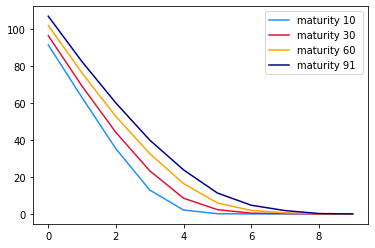

In [ ]:
#plot option data
plt.plot(data_options[0,:][:], color='dodgerblue',label="maturity 10 ")
plt.plot(data_options[1,:][:], color='crimson',label="maturity 30 ")
plt.plot(data_options[2,:][:], color='orange',label="maturity 60 ")
plt.plot(data_options[3,:][:], color='darkblue',label="maturity 91 ")
plt.legend()

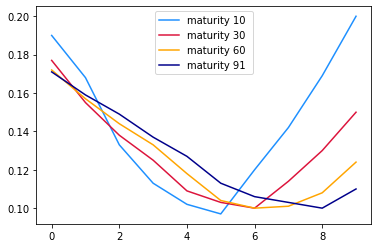

In [ ]:
#plot implied volatilities
plt.plot(ivol[0,:][:], color='dodgerblue',label="maturity 10 ")
plt.plot(ivol[1,:][:], color='crimson',label="maturity 30 ")
plt.plot(ivol[2,:][:], color='orange',label="maturity 60 ")
plt.plot(ivol[3,:][:], color='darkblue',label="maturity 91 ")
plt.legend()

In [26]:
np.where(np.array([44, 107, 175,237])==44)

(array([0]),)

epoch: 0
pred tensor([[-3.0018e+02,  5.0270e+02,  5.2289e+02,  1.5787e+02, -1.0016e+02,
         -5.2947e+02,  3.6680e+02,  3.8179e+02, -9.9716e+01,  4.1826e+02],
        [ 1.1176e+02,  6.5520e+01,  5.6541e+01,  2.3052e+01,  1.6569e+01,
          2.0946e+01, -1.0932e+00,  2.2631e+01, -1.1921e+01,  1.2275e+01],
        [ 4.3780e+02,  1.1426e+03,  5.0225e+01,  1.4088e+03, -1.9591e+03,
          8.6738e+02,  1.3194e+03, -1.1580e+03, -7.6641e+02, -2.0777e+02],
        [-9.1409e+02, -3.8668e+02, -4.0922e+02, -9.8304e+02, -1.2882e+03,
          1.6519e+03, -3.1970e+01,  2.1128e+03,  8.3894e+01, -2.9438e+02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e

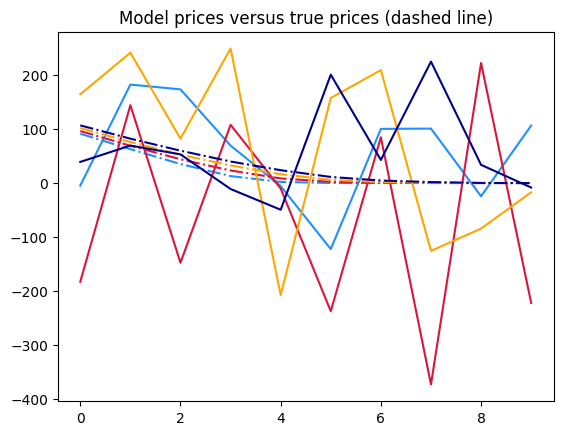

epoch=0, loss=145.1389
epoch: 1
iteration 6, sum_variance=64326217728.0000, time_forward=0.6249, time_backward=0.1131
iteration 7, sum_variance=51206991872.0000, time_forward=0.6060, time_backward=0.1111
iteration 8, sum_variance=44488810496.0000, time_forward=0.5969, time_backward=0.1089
iteration 9, sum_variance=43484508160.0000, time_forward=0.5992, time_backward=0.1098
iteration 10, sum_variance=42008776704.0000, time_forward=0.6061, time_backward=0.1245
pred: tensor([[   6.4798,  168.7458,  134.9780,   49.6024,   18.4798,  -99.4458,
           85.2659,   80.4729,  -29.1870,   80.8698],
        [-174.1722,  118.9844,  -72.7115,   82.6381,   16.2657, -147.4458,
           71.6686, -286.7094,  168.8080, -145.7460],
        [ 154.9389,  187.7059,   79.0293,  178.4163, -164.2281,  141.9887,
          187.1194,  -80.0878,  -62.4790,  -27.4767],
        [  62.2727,   77.5845,   82.2819,   23.0482,   -1.8708,  159.3877,
           58.5213,  170.0409,   49.4982,   -4.6447]], device='cuda:0

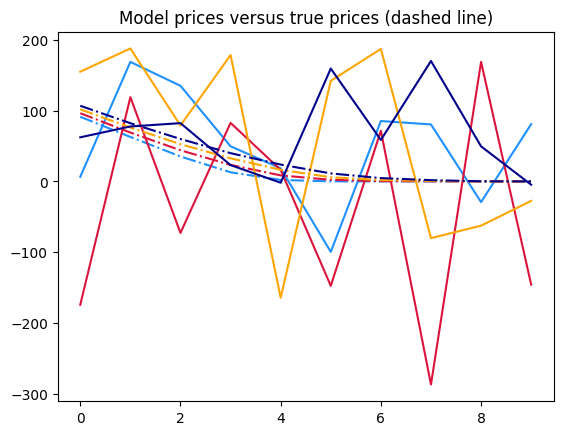

epoch=1, loss=112.5120
epoch: 2
pred tensor([[  298.9429,  -155.7083,  -147.0965,    -5.4834,    25.1229,   268.8806,
          -174.6909,  -174.1266,    69.8578,  -185.9781],
        [  715.2858,    16.8324,   372.9900,   -11.8778,    91.9708,   412.8831,
           -85.6571,   667.7482,  -339.7283,   325.9747],
        [   33.8239,  -111.7464,    91.7455,  -198.3949,   584.2030,  -190.5641,
          -329.8842,   289.6325,   210.2528,   103.9316],
        [ 1604.7369,   845.4453,   362.6237,  1332.0095,  1587.2860, -2216.4531,
          -214.6252, -2853.6997,  -484.2013,   514.4798]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 

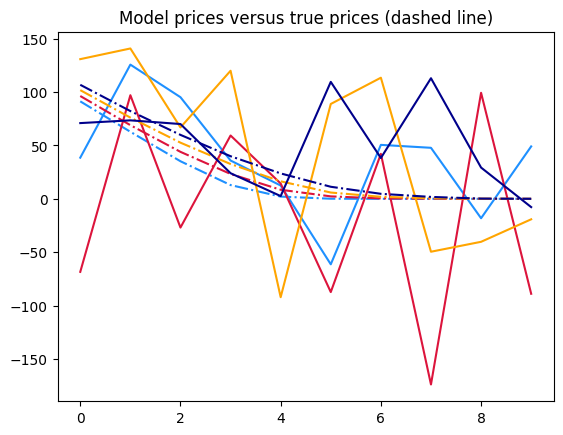

epoch=2, loss=68.7608
epoch: 3
iteration 16, sum_variance=17069570048.0000, time_forward=0.5896, time_backward=0.1093
iteration 17, sum_variance=17263706112.0000, time_forward=0.6054, time_backward=0.1094
iteration 18, sum_variance=14240849920.0000, time_forward=0.6011, time_backward=0.1081
iteration 19, sum_variance=13056953344.0000, time_forward=0.5827, time_backward=0.1117
iteration 20, sum_variance=10660242432.0000, time_forward=0.6020, time_backward=0.1221
pred: tensor([[  44.3182,  118.4782,   74.4652,   26.8040,   23.8858,  -48.4808,
           43.3497,   37.1527,  -21.1454,   35.7152],
        [ -63.3199,   84.8330,   12.2809,   47.5097,   24.2587,  -39.2510,
           34.7577, -124.2364,   70.4033,  -46.7292],
        [ 125.7940,  112.4679,   64.1401,   84.2525,  -68.6924,   81.4946,
          102.2630,  -26.5632,  -29.1614,  -26.2463],
        [  85.1664,   78.8310,   85.0741,   44.9885,   31.8499,   83.9799,
           44.2804,   79.6199,   38.5204,   -6.6508]], device='cud

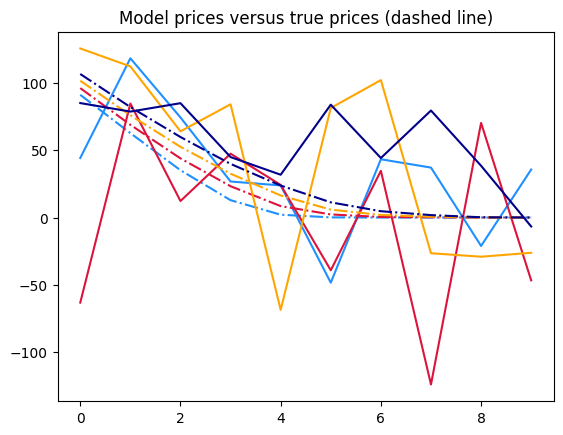

epoch=3, loss=53.2899
epoch: 4
pred tensor([[ 677.5112, -576.9524, -338.3306,   14.1632, -106.3018,  682.0099,
         -490.0324, -438.2682,  259.7653, -436.3607],
        [ 573.6794,   55.9321,  187.8879,   22.4633,   39.3186,  185.6195,
          -54.2417,  386.8645, -192.7022,  138.6421],
        [ 221.0868,  257.4225,   34.8591,  265.9944, -709.0153,  383.7669,
          573.3948, -277.7961, -247.5763, -204.9892],
        [ 218.3955,  151.1079,   57.2891,  118.1482,  105.8628, -105.7710,
          -16.0388, -158.8223,  -66.1494,   52.5392]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-

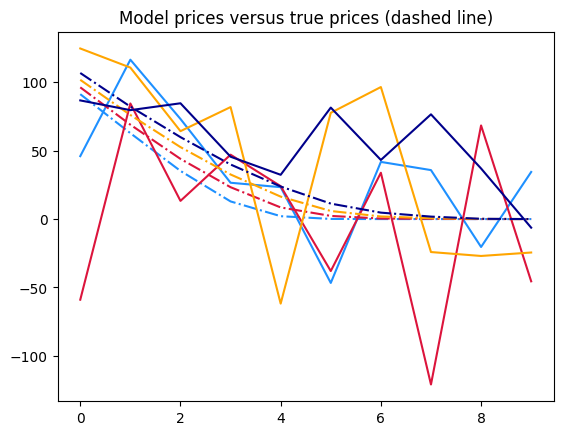

epoch=4, loss=51.2529
epoch: 5
iteration 26, sum_variance=9440371712.0000, time_forward=0.6143, time_backward=0.1112
iteration 27, sum_variance=8219543552.0000, time_forward=0.6046, time_backward=0.1139
iteration 28, sum_variance=7789953024.0000, time_forward=0.6057, time_backward=0.1438
iteration 29, sum_variance=8128603136.0000, time_forward=0.8710, time_backward=0.1409
iteration 30, sum_variance=6084033024.0000, time_forward=0.9170, time_backward=0.1712
pred: tensor([[ 51.5500, 110.8473,  58.1484,  24.2334,  28.6745, -34.9454,  36.6093,
          31.8601, -22.2392,  27.6730],
        [-55.1291,  76.7203,  35.2612,  42.3749,  22.3318,  -5.1115,  24.4259,
         -67.0086,  41.7552, -18.2717],
        [117.3922,  91.1852,  67.6408,  64.2264, -35.6297,  66.9061,  82.2153,
          -9.9936, -16.7924, -26.7408],
        [100.8057,  89.1019,  83.0962,  57.3481,  51.1851,  60.9185,  44.9548,
          56.4098,  35.5402,  -5.1086]], device='cuda:0')
target tensor([[9.1300e+01, 6.2800e+01,

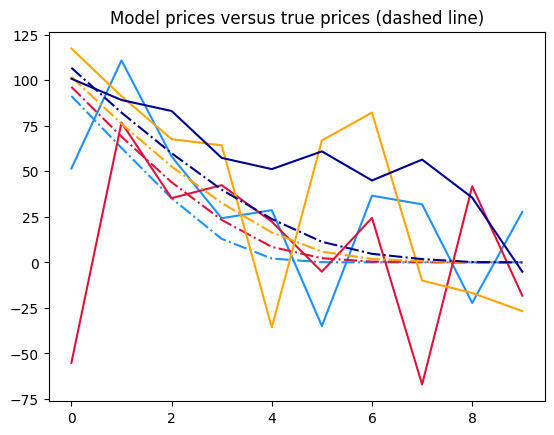

epoch=5, loss=40.8188
epoch: 6
pred tensor([[ 146.5402,    6.1712,   23.5251,   28.5053,   -5.5971,   62.0821,
          -41.7567,  -39.5581,   29.6896,  -36.8677],
        [-435.4510,   74.5946,  -19.5849,   45.1142,    6.7190,  -64.1290,
           53.8682, -249.2241,  136.9245,  -64.3310],
        [  47.4151,   60.6504,   78.4552,  -37.1443,  634.9813, -265.0205,
         -456.4038,  217.2454,  200.8187,  244.4088],
        [ 182.9597,  127.4876,   59.0145,   85.8821,   43.3949,  -52.0444,
          -32.0864, -114.3573,  -79.4788,   58.9186]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-

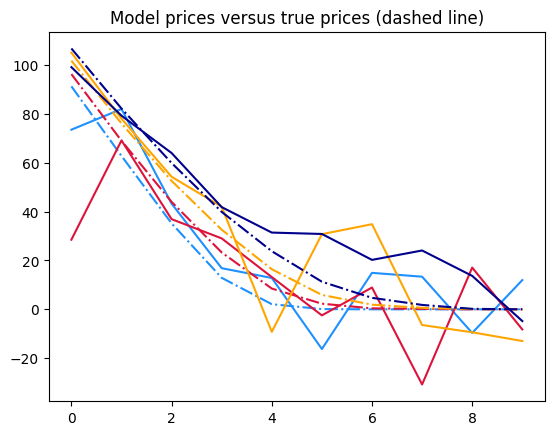

epoch=6, loss=17.4260
epoch: 7
iteration 36, sum_variance=2090676352.0000, time_forward=0.8610, time_backward=0.1979
iteration 37, sum_variance=1842496384.0000, time_forward=0.8623, time_backward=0.1240
iteration 38, sum_variance=1804717824.0000, time_forward=0.5926, time_backward=0.1075
iteration 39, sum_variance=1664068096.0000, time_forward=0.6444, time_backward=0.1140
iteration 40, sum_variance=1368753920.0000, time_forward=0.6105, time_backward=0.1113
pred: tensor([[ 76.5460,  78.2446,  38.6434,  18.6940,  12.7500, -12.0602,  14.2855,
          11.5972,  -8.3099,   9.7992],
        [ 37.2764,  67.2975,  41.4386,  27.4144,   9.4791,   3.8348,   3.0207,
         -11.8331,   6.1453,   0.6519],
        [102.0959,  75.0046,  56.1087,  40.8629,   2.8690,  26.5244,  27.3340,
          -3.5119,  -4.4465, -13.4362],
        [102.6313,  84.2526,  61.5074,  45.9787,  34.4548,  26.4884,  19.0207,
          20.4381,   9.5387,  -3.3762]], device='cuda:0')
target tensor([[9.1300e+01, 6.2800e+01,

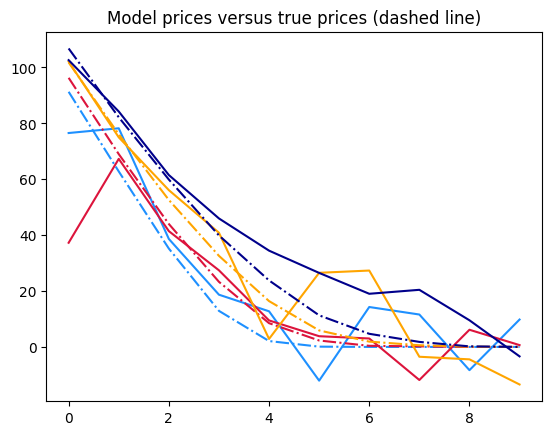

epoch=7, loss=13.7674
epoch: 8
pred tensor([[ -14.0216,  175.8074,   50.1958,   25.7518,   51.7207,  -97.8389,
          100.8234,   83.1549,  -59.6860,   70.6239],
        [-248.0701,   56.1552,   15.6742,   20.9724,  -22.9782,  -17.0776,
           -1.1245,  -76.4780,   35.2814,    4.4081],
        [  95.7449,   99.2948,   35.4725,  -20.2809,  324.6291, -161.8864,
         -267.4412,  122.9907,   82.7055,  198.9706],
        [ 177.5336,   55.9977,   66.1853,   15.6456,  -36.0905,  -87.1033,
          -90.9351, -205.2107, -109.3221,   77.1034]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-

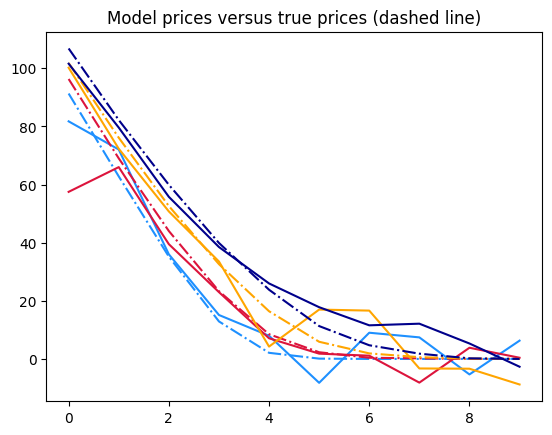

epoch=8, loss=8.6812
epoch: 9
iteration 46, sum_variance=704516864.0000, time_forward=0.6173, time_backward=0.1089
iteration 47, sum_variance=656949440.0000, time_forward=0.5976, time_backward=0.1114
iteration 48, sum_variance=641577728.0000, time_forward=0.6046, time_backward=0.1090
iteration 49, sum_variance=565075520.0000, time_forward=0.6065, time_backward=0.1109
iteration 50, sum_variance=459091520.0000, time_forward=0.6019, time_backward=0.1129
pred: tensor([[ 8.3645e+01,  6.8955e+01,  3.5177e+01,  1.5587e+01,  7.5586e+00,
         -6.0091e+00,  8.1422e+00,  6.7734e+00, -3.4834e+00,  5.4000e+00],
        [ 6.6492e+01,  6.5171e+01,  4.1305e+01,  2.2389e+01,  5.3024e+00,
          2.6396e+00, -2.4076e+00, -1.2117e+00, -4.8475e-02,  3.6834e+00],
        [ 9.8892e+01,  7.1063e+01,  4.9889e+01,  3.4503e+01,  9.9517e+00,
          1.4827e+01,  1.1947e+01, -2.0700e+00, -1.4840e+00, -7.2669e+00],
        [ 1.0225e+02,  8.1174e+01,  5.6144e+01,  4.1037e+01,  2.6377e+01,
          1.7177e+

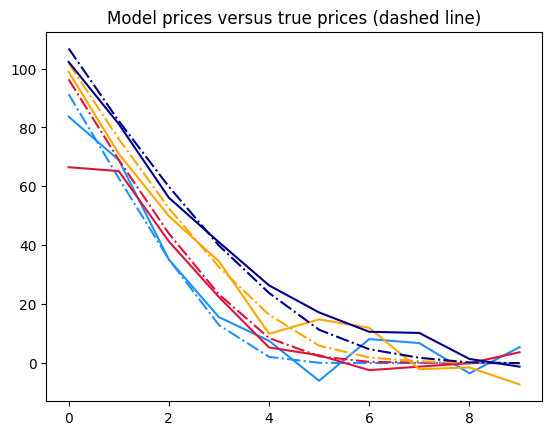

epoch=9, loss=6.6824
epoch: 10
pred tensor([[   8.4260,  139.8108,   39.4010,   27.9127,   44.4289,  -73.1389,
           89.8152,   75.0539,  -38.4827,   59.9587],
        [ -21.4897,   58.2479,   36.1559,   17.5431,  -13.8038,   -3.3624,
          -15.0516,   -6.1287,   -0.3540,   15.1939],
        [ 116.5932,  109.6218,   49.5782,  -26.1607,  140.7769,  -82.5937,
         -117.9716,   67.1629,   28.1972,  117.8265],
        [ 137.3704,   35.3222,   51.9296,  -23.0006,  -25.4584,  -43.8662,
          -42.4887,  -99.0276,   -4.6432,   23.8925]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-

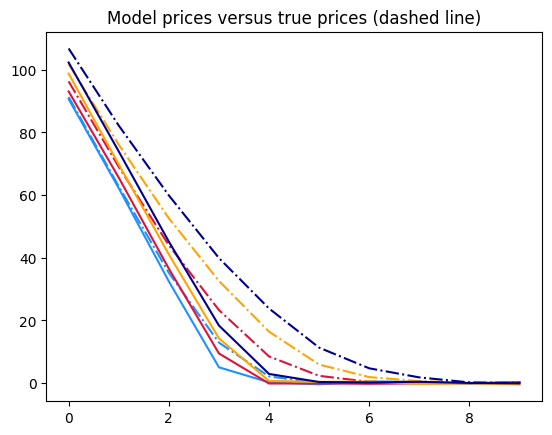

epoch=10, loss=8.0219
epoch: 11
iteration 56, sum_variance=24049376.0000, time_forward=0.6062, time_backward=0.1127
iteration 57, sum_variance=21209128.0000, time_forward=0.6411, time_backward=0.1178
iteration 58, sum_variance=19799696.0000, time_forward=0.6170, time_backward=0.1114
iteration 59, sum_variance=17583886.0000, time_forward=0.6144, time_backward=0.1090
iteration 60, sum_variance=13434610.0000, time_forward=0.5931, time_backward=0.1240
pred: tensor([[ 9.0778e+01,  6.2056e+01,  3.2477e+01,  5.0128e+00,  1.6803e-01,
         -3.3290e-01,  3.4124e-01,  3.3650e-01, -1.1687e-01,  2.5397e-01],
        [ 9.3709e+01,  6.5614e+01,  3.6584e+01,  9.4248e+00,  3.2192e-04,
         -2.0104e-01, -3.8399e-01,  4.3876e-02,  8.3051e-03,  2.5128e-01],
        [ 9.8766e+01,  6.9837e+01,  4.0994e+01,  1.4182e+01,  8.7894e-01,
          2.2837e-01,  2.7958e-01, -1.7821e-01,  1.1053e-02, -3.2451e-01],
        [ 1.0243e+02,  7.3955e+01,  4.5260e+01,  1.8424e+01,  2.7163e+00,
          2.3627e-01,

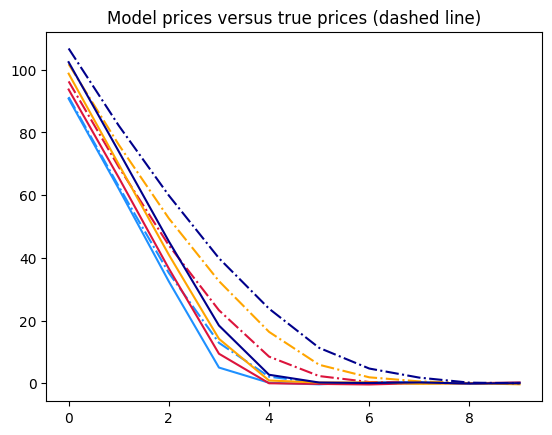

epoch=11, loss=8.0182
epoch: 12
pred tensor([[ 43.3953, 101.7273,  39.9414,  14.0098,  23.4539, -46.5018,  47.8831,
          47.1233, -16.2652,  35.6210],
        [-55.9014,  52.1862,  34.9637,  -4.1826, -28.8025, -26.9585, -51.8933,
           6.0543,   1.1033,  33.7810],
        [117.5385,  96.5579,  59.6328, -20.3108,  70.1795, -52.1955, -66.6917,
          42.9689,  -3.4005,  77.6066],
        [104.5013,  49.9411,  27.6497, -21.8173,   1.7072, -16.5836,  -9.2143,
         -35.9605,  10.0269,  -3.7712]], device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-01, 1.0000e-01, 0.0000e+00],
        [1.0680e+

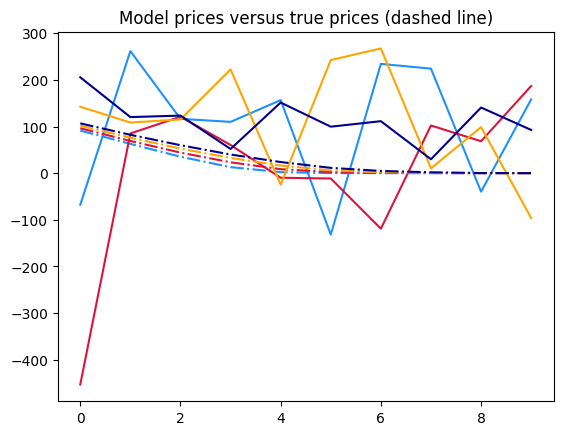

epoch=12, loss=149.8337
epoch: 13
iteration 66, sum_variance=22566760448.0000, time_forward=0.6098, time_backward=0.1156
iteration 67, sum_variance=15042084864.0000, time_forward=0.6110, time_backward=0.1133
iteration 68, sum_variance=10440237056.0000, time_forward=0.8251, time_backward=0.1542
iteration 69, sum_variance=20420599808.0000, time_forward=0.9030, time_backward=0.1791
iteration 70, sum_variance=19991238656.0000, time_forward=0.8101, time_backward=0.1241
pred: tensor([[ -18.2744,  232.2453,  105.9474,   58.7295,  133.9305,  -85.1555,
          136.2889,  148.3776,  -26.4056,  114.8345],
        [-250.8802,  107.8406,  159.5632,  112.7529,   57.4996,    2.6919,
          -39.7151,  133.9056,  117.4586,  202.6453],
        [ 179.3567,  132.3848,  120.6791,  166.8782,   21.0584,  158.5827,
          192.0828,   64.0775,  102.0407,   -5.1873],
        [ 216.0950,  110.2406,  130.6068,   79.4221,  186.5470,  128.6243,
          148.3589,   65.6567,  153.9905,  105.9907]], device='

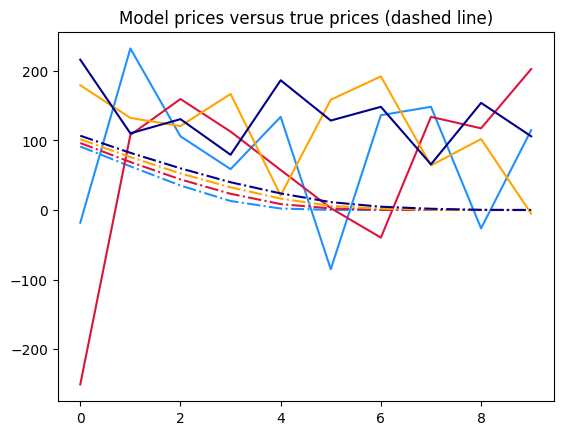

epoch=13, loss=119.5869
epoch: 14
pred tensor([[ -48.6661,  260.7834,  110.2211,   55.7504,  149.2198, -115.7800,
          156.6776,  172.7828,  -37.4318,  136.0769],
        [1048.9065,  217.1678,   60.3718,  121.0333,  207.5896,  294.3624,
          357.7242,  -51.3686,  -59.7510, -285.1129],
        [ 153.7662, -104.4743, -114.0990,  313.3619, -721.0031,  380.6996,
          694.3757, -226.6749,  162.0459, -575.0634],
        [ 322.4489, -392.9397, -152.3835, -466.6475,  382.4522,   18.0293,
          217.0014, -339.1032,  416.5826,  136.4726]], device='cuda:0',
       grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.000

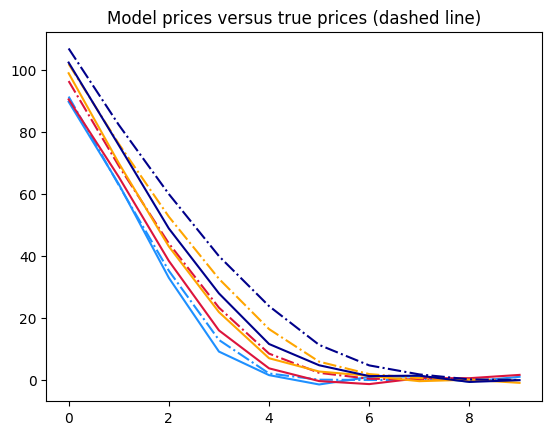

epoch=14, loss=5.2135
epoch: 15
iteration 76, sum_variance=31734272.0000, time_forward=0.9747, time_backward=0.1100
iteration 77, sum_variance=26592784.0000, time_forward=0.5915, time_backward=0.1104
iteration 78, sum_variance=21751916.0000, time_forward=0.6124, time_backward=0.1109
iteration 79, sum_variance=17885060.0000, time_forward=0.6126, time_backward=0.1122
iteration 80, sum_variance=13945343.0000, time_forward=0.6068, time_backward=0.1093
pred: tensor([[ 9.0200e+01,  6.2722e+01,  3.2921e+01,  9.1205e+00,  1.3147e+00,
         -7.9980e-01,  5.0140e-01,  4.3371e-01, -3.3867e-01,  6.0687e-01],
        [ 9.2199e+01,  6.5768e+01,  3.8166e+01,  1.5984e+01,  3.9181e+00,
          1.7905e-01, -7.9358e-01,  2.9304e-01,  4.4263e-01,  9.7524e-01],
        [ 9.8892e+01,  7.0166e+01,  4.3187e+01,  2.1739e+01,  7.4482e+00,
          2.4962e+00,  9.0672e-01, -1.9274e-01,  7.8256e-02, -5.3997e-01],
        [ 1.0240e+02,  7.5061e+01,  4.8445e+01,  2.7034e+01,  1.1709e+01,
          4.6930e+00,

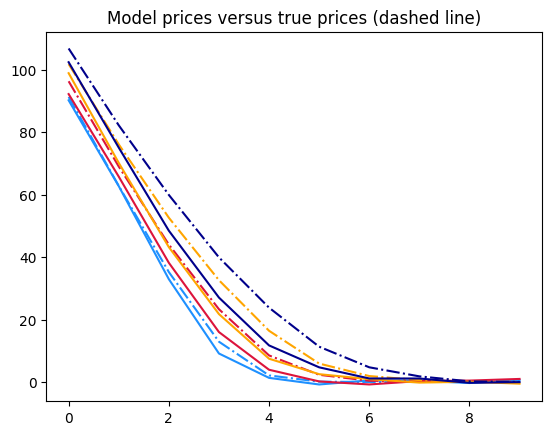

epoch=15, loss=5.1965
epoch: 16
pred tensor([[ 85.2519,  67.9945,  34.0298,   7.9429,   3.9668,  -5.2257,   3.2729,
           2.7759,  -2.1512,   3.9128],
        [145.4259,  66.1530,  34.9091,  15.7972,  10.6596,  10.0380,  16.8362,
          -5.9253,  -8.5768, -19.2715],
        [ 99.0510,  65.8872,  36.0363,  25.7210, -17.8496,   6.8918,  13.9296,
          -9.4877,   2.9755, -18.3112],
        [ 98.4331,  96.2600,  58.5189,  42.8732,  -1.4504,  11.6675,  -8.7743,
          26.3015, -10.0604,  -1.2645]], device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-01, 1.0000e-01, 0.0000e+00],
        [1.0680e+

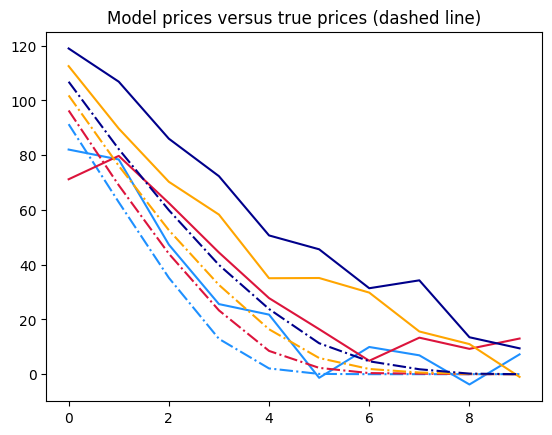

epoch=16, loss=18.5762
epoch: 17
iteration 86, sum_variance=131779904.0000, time_forward=0.6215, time_backward=0.1102
iteration 87, sum_variance=103222144.0000, time_forward=0.5997, time_backward=0.1135
iteration 88, sum_variance=80047408.0000, time_forward=0.6107, time_backward=0.1120
iteration 89, sum_variance=64854188.0000, time_forward=0.6503, time_backward=0.1185
iteration 90, sum_variance=40686956.0000, time_forward=0.6296, time_backward=0.1220
pred: tensor([[ 88.9959,  70.3713,  45.3064,  27.8305,  18.1664,   2.7225,   8.6076,
           3.5542,  -0.6248,   3.8793],
        [ 89.4675,  80.1961,  61.2807,  43.8648,  27.8152,  20.3558,  12.8363,
           9.2800,   4.3618,   3.7164],
        [111.6417,  90.0299,  70.3495,  58.1424,  39.6427,  35.0331,  27.5202,
          17.0025,   9.2480,   1.5798],
        [118.9929, 100.0387,  84.7610,  67.9722,  54.0000,  45.9028,  33.7873,
          30.8497,  17.3013,  11.5593]], device='cuda:0')
target tensor([[9.1300e+01, 6.2800e+01, 3.520

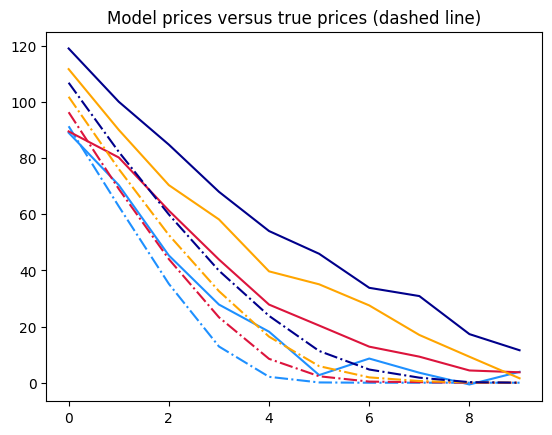

epoch=17, loss=17.5889
epoch: 18
pred tensor([[ 52.0089, 101.6100,  47.8000,  26.8130,  40.5900, -49.9867,  53.3028,
          20.2572,  -8.3163,  40.5693],
        [ -7.2212,  81.5886,  64.3371,  36.8922,  -4.5054,   6.3049,  -5.5163,
           6.3234,   7.4065,  22.3600],
        [124.5944, 109.7719, 114.5015,  36.4533, 121.7844,  10.0013, -13.1773,
          54.2823,  24.4714,  71.9349],
        [127.6460, 105.6348,  69.0307,  65.0328,  59.6694,  26.7883,  40.4312,
          -2.8211,   9.6315,  -4.3124]], device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-01, 1.0000e-01, 0.0000e+00],
        [1.0680e

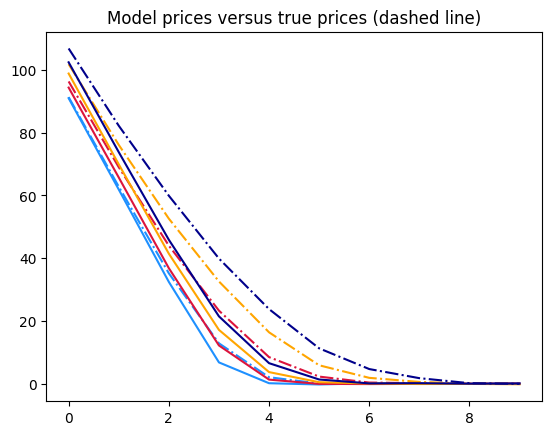

epoch=18, loss=6.9691
epoch: 19
iteration 96, sum_variance=954401.7500, time_forward=0.6646, time_backward=0.1137
iteration 97, sum_variance=682221.8125, time_forward=0.6292, time_backward=0.1083
iteration 98, sum_variance=445671.9375, time_forward=0.5959, time_backward=0.1229
iteration 99, sum_variance=226292.7188, time_forward=0.5955, time_backward=0.1126
iteration 100, sum_variance=82902.5625, time_forward=0.6109, time_backward=0.1079
pred: tensor([[ 9.1100e+01,  6.1799e+01,  3.2474e+01,  6.8473e+00,  1.4045e-01,
          5.0599e-03,  4.1967e-03,  5.6565e-02,  1.8143e-02,  2.1226e-02],
        [ 9.4779e+01,  6.5729e+01,  3.6816e+01,  1.2208e+01,  1.4899e+00,
         -2.2941e-02, -4.0606e-02,  7.7137e-03,  2.1836e-02, -2.4060e-03],
        [ 9.8841e+01,  6.9959e+01,  4.1527e+01,  1.7150e+01,  3.8963e+00,
          4.5126e-01,  1.4511e-02,  5.2901e-03,  2.0198e-02, -3.8783e-03],
        [ 1.0245e+02,  7.3794e+01,  4.5782e+01,  2.1506e+01,  6.5653e+00,
          1.2784e+00,  1.6427e-

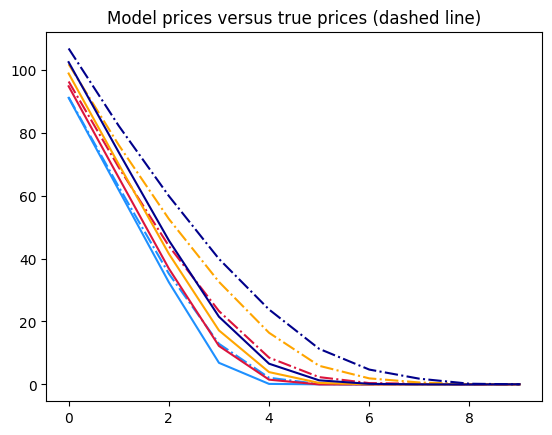

epoch=19, loss=6.9601
epoch: 20
pred tensor([[ 9.1100e+01,  6.1844e+01,  3.2536e+01,  6.6663e+00,  1.7588e-01,
          1.2004e-02,  1.6219e-02,  1.1688e-01,  4.5929e-02,  4.3392e-02],
        [ 9.4808e+01,  6.5793e+01,  3.6874e+01,  1.1772e+01,  1.2237e+00,
         -1.0045e-01, -8.2680e-02,  4.1016e-02,  3.4258e-02,  3.2413e-02],
        [ 9.9215e+01,  7.0157e+01,  4.1958e+01,  1.5876e+01,  3.5477e+00,
          1.8570e-01,  1.7584e-01, -9.4791e-02, -7.9078e-01, -1.5037e-02],
        [ 1.0248e+02,  7.3955e+01,  4.5839e+01,  2.1174e+01,  6.4236e+00,
          1.1083e+00,  3.2616e-02,  1.9304e-02,  1.5279e-01, -1.4310e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

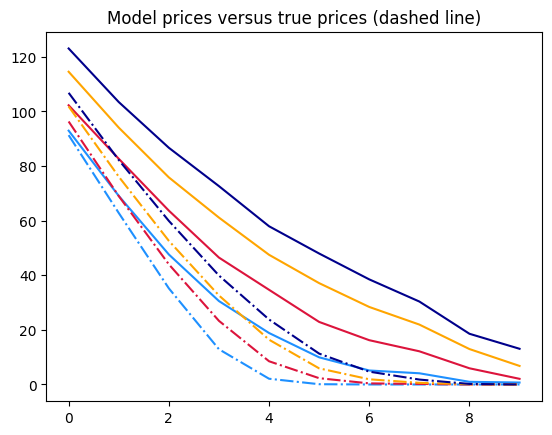

epoch=20, loss=20.1483
epoch: 21
iteration 106, sum_variance=1572192.2500, time_forward=0.6345, time_backward=0.1115
iteration 107, sum_variance=793087.3750, time_forward=0.6543, time_backward=0.1715
iteration 108, sum_variance=256914.0938, time_forward=0.8133, time_backward=0.1462
iteration 109, sum_variance=257601.6250, time_forward=0.9637, time_backward=0.1791
iteration 110, sum_variance=224922.1875, time_forward=0.6922, time_backward=0.1092
pred: tensor([[9.3734e+01, 6.8437e+01, 4.6885e+01, 3.0041e+01, 1.7765e+01, 9.7965e+00,
         4.9591e+00, 2.3580e+00, 4.4763e-01, 4.7235e-02],
        [1.0468e+02, 8.2710e+01, 6.3768e+01, 4.7944e+01, 3.5153e+01, 2.5074e+01,
         1.7432e+01, 1.1977e+01, 5.2785e+00, 2.1886e+00],
        [1.1428e+02, 9.3799e+01, 7.5816e+01, 6.0388e+01, 4.7608e+01, 3.7028e+01,
         2.8575e+01, 2.1804e+01, 1.2367e+01, 6.9431e+00],
        [1.2295e+02, 1.0353e+02, 8.6357e+01, 7.1398e+01, 5.8429e+01, 4.7419e+01,
         3.8230e+01, 3.0637e+01, 1.9470e+01, 1.

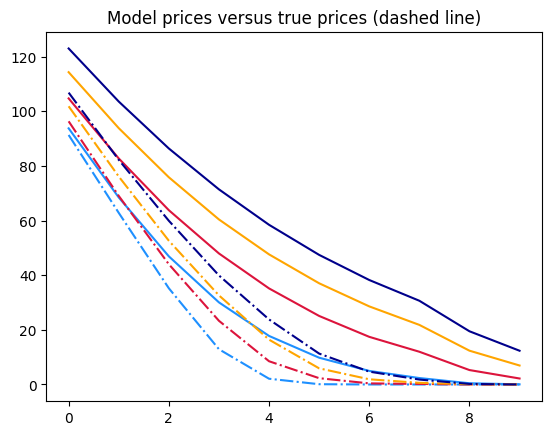

epoch=21, loss=20.1611
epoch: 22
pred tensor([[ 9.5995e+01,  6.9857e+01,  4.8534e+01,  3.2125e+01,  1.9303e+01,
          1.0936e+01,  5.2171e+00,  2.3597e+00,  1.0637e+00, -1.1606e-01],
        [ 1.0915e+02,  8.6027e+01,  6.6987e+01,  5.1039e+01,  3.8134e+01,
          2.7176e+01,  1.8895e+01,  1.3841e+01,  6.0755e+00,  2.9748e+00],
        [ 1.2119e+02,  1.0087e+02,  8.1360e+01,  6.5457e+01,  5.0804e+01,
          4.1828e+01,  3.0873e+01,  2.3631e+01,  1.5193e+01,  7.4221e+00],
        [ 1.2597e+02,  1.0764e+02,  9.0481e+01,  7.3852e+01,  6.2066e+01,
          5.1085e+01,  4.1605e+01,  3.3922e+01,  2.2839e+01,  1.4230e+01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e

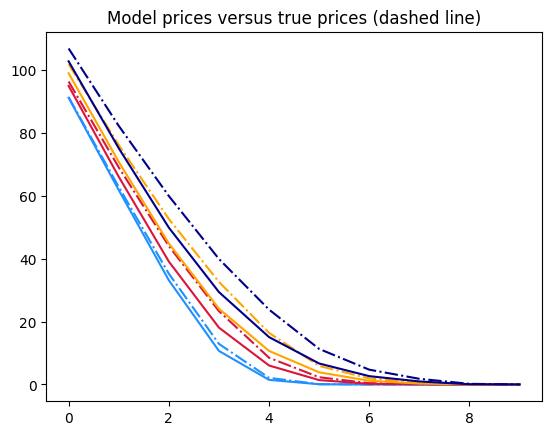

epoch=22, loss=4.0916
epoch: 23
iteration 116, sum_variance=21794.3926, time_forward=0.6101, time_backward=0.1129
iteration 117, sum_variance=22099.4883, time_forward=0.6068, time_backward=0.1084
iteration 118, sum_variance=23785.7129, time_forward=0.6209, time_backward=0.1122
iteration 119, sum_variance=23333.7773, time_forward=0.5990, time_backward=0.1140
iteration 120, sum_variance=22525.7188, time_forward=0.6099, time_backward=0.1187
pred: tensor([[ 9.1139e+01,  6.1799e+01,  3.3119e+01,  1.0662e+01,  1.4656e+00,
          6.8011e-02, -2.6350e-03, -2.8720e-03,  2.3523e-03, -1.9671e-03],
        [ 9.4901e+01,  6.6030e+01,  3.9076e+01,  1.8067e+01,  6.0285e+00,
          1.3884e+00,  2.0308e-01,  3.0315e-02,  1.1672e-03,  4.5002e-03],
        [ 9.8923e+01,  7.0752e+01,  4.4834e+01,  2.4072e+01,  1.0661e+01,
          3.8663e+00,  1.1803e+00,  2.9352e-01,  7.8916e-03,  4.3421e-03],
        [ 1.0271e+02,  7.5102e+01,  4.9855e+01,  2.9367e+01,  1.5056e+01,
          6.6687e+00,  2.6444e+

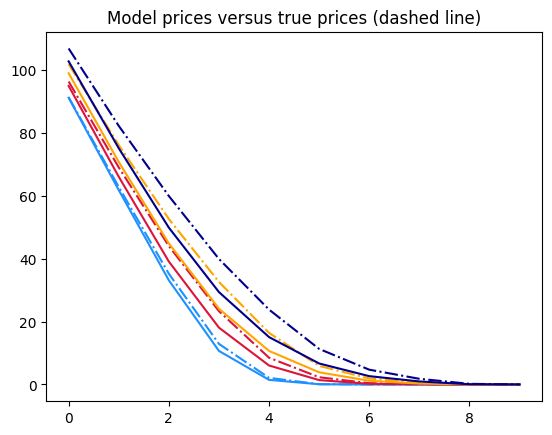

epoch=23, loss=4.0916
epoch: 24
pred tensor([[ 8.9976e+01,  6.0953e+01,  3.2218e+01,  9.8095e+00,  1.4531e+00,
          6.2044e-02,  2.0905e-01,  1.7311e-01, -1.4179e-01,  1.1857e-01],
        [ 9.2186e+01,  6.3971e+01,  3.6983e+01,  1.6198e+01,  4.7613e+00,
          1.0229e+00,  2.5756e-01, -4.1716e-01, -7.9901e-02, -3.0807e-01],
        [ 9.7347e+01,  6.9033e+01,  4.3517e+01,  2.3145e+01,  1.0619e+01,
          3.6814e+00,  1.4082e+00,  5.0590e-01, -2.8661e-02,  3.5855e-01],
        [ 1.0174e+02,  7.3915e+01,  4.8737e+01,  2.8841e+01,  1.4850e+01,
          7.0216e+00,  2.9486e+00,  1.1068e+00, -6.0739e-02,  9.3173e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

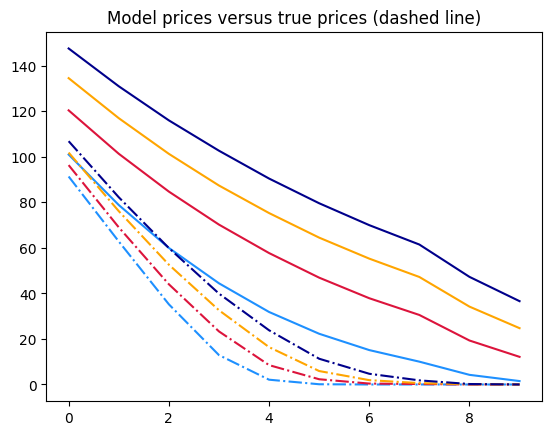

epoch=24, loss=41.7574
epoch: 25
iteration 126, sum_variance=598710.0000, time_forward=0.6219, time_backward=0.1129
iteration 127, sum_variance=651410.7500, time_forward=0.6036, time_backward=0.1108
iteration 128, sum_variance=612361.4375, time_forward=0.6375, time_backward=0.1113
iteration 129, sum_variance=621264.3750, time_forward=0.6458, time_backward=0.1097
iteration 130, sum_variance=674722.6250, time_forward=0.6122, time_backward=0.1251
pred: tensor([[100.9337,  78.7909,  59.9494,  44.4158,  31.8271,  22.2634,  15.1008,
          10.0181,   4.2277,   1.5003],
        [120.3314, 101.2800,  84.6716,  70.1786,  57.6903,  46.8902,  37.8600,
          30.5105,  19.2986,  12.1182],
        [134.4752, 116.9147, 101.2522,  87.3513,  75.2568,  64.4690,  55.2511,
          47.1934,  34.1843,  24.7172],
        [147.5048, 130.9198, 115.9478, 102.6301,  90.4081,  79.5626,  69.9514,
          61.4359,  47.2452,  36.5758]], device='cuda:0')
target tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 

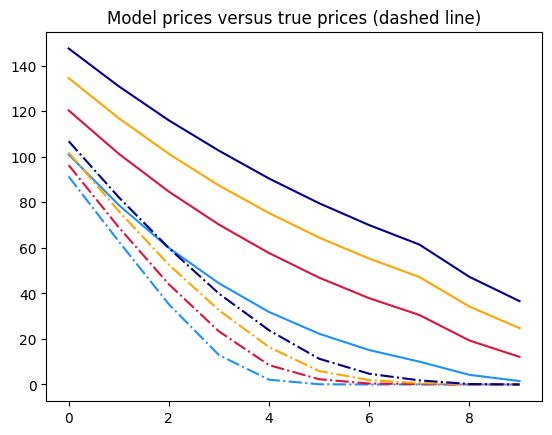

epoch=25, loss=41.7581
epoch: 26
pred tensor([[ 94.0869,  74.5749,  55.7583,  39.4089,  28.6648,  19.6784,  14.7743,
          10.1106,   2.6810,   1.9420],
        [111.3764,  95.6275,  79.1184,  64.4259,  51.7927,  43.2910,  35.4460,
          26.2922,  17.2645,   9.7432],
        [132.4065, 115.3186, 100.9317,  87.1661,  75.9941,  63.5469,  55.6263,
          47.2321,  33.3265,  24.9976],
        [142.4047, 123.1536, 107.8933,  99.0029,  83.6565,  73.2688,  65.1333,
          56.8038,  40.2750,  33.2200]], device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+01, 5.2600e+01, 3.2600e+01, 1.6400e+01, 5.9000e+00,
         1.9000e+00, 6.0000e-01, 1.0000e-01, 0.0000e+00],
        [1.0680e

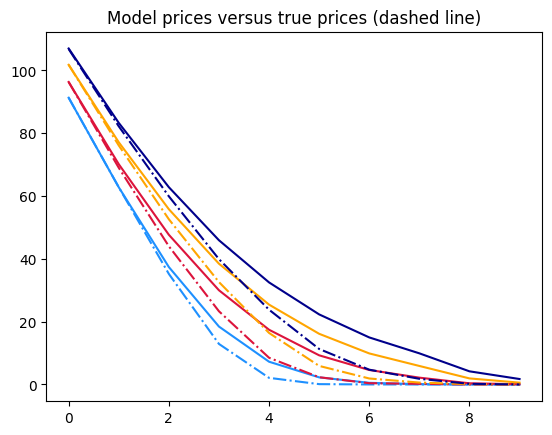

epoch=26, loss=5.0872
epoch: 27
iteration 136, sum_variance=78920.9141, time_forward=0.6194, time_backward=0.1152
iteration 137, sum_variance=79044.7969, time_forward=0.6114, time_backward=0.1106
iteration 138, sum_variance=76798.9062, time_forward=0.6031, time_backward=0.1117
iteration 139, sum_variance=86556.7344, time_forward=0.6142, time_backward=0.1092
iteration 140, sum_variance=78027.2031, time_forward=0.6098, time_backward=0.1430
pred: tensor([[ 9.1294e+01,  6.2791e+01,  3.7388e+01,  1.8433e+01,  7.2386e+00,
          2.2532e+00,  5.2175e-01,  9.4247e-02,  1.0969e-02, -7.6121e-03],
        [ 9.6301e+01,  7.0138e+01,  4.7654e+01,  2.9987e+01,  1.7415e+01,
          9.2759e+00,  4.6031e+00,  2.1630e+00,  3.6518e-01,  7.3899e-02],
        [ 1.0178e+02,  7.7120e+01,  5.5799e+01,  3.8443e+01,  2.5421e+01,
          1.6129e+01,  9.8796e+00,  5.8897e+00,  1.9240e+00,  5.7411e-01],
        [ 1.0697e+02,  8.3290e+01,  6.2809e+01,  4.5916e+01,  3.2488e+01,
          2.2305e+01,  1.4973e+

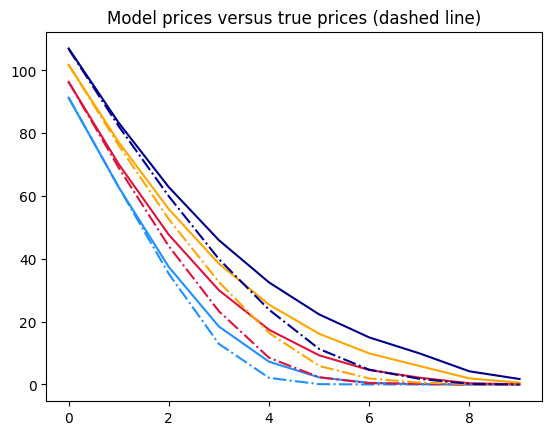

epoch=27, loss=5.0873
epoch: 28
pred tensor([[ 9.1891e+01,  6.3155e+01,  3.7463e+01,  1.8415e+01,  6.9962e+00,
          2.0503e+00,  4.1803e-01, -1.7428e-02,  6.9485e-02, -5.7355e-02],
        [ 9.6711e+01,  7.0518e+01,  4.7770e+01,  2.9874e+01,  1.7227e+01,
          9.1101e+00,  4.6462e+00,  2.3165e+00,  4.6247e-01,  1.3721e-01],
        [ 1.0268e+02,  7.7932e+01,  5.6009e+01,  3.8687e+01,  2.5353e+01,
          1.5949e+01,  9.3575e+00,  5.4915e+00,  1.6029e+00,  1.9519e-01],
        [ 1.0715e+02,  8.3296e+01,  6.2515e+01,  4.5276e+01,  3.1428e+01,
          2.1266e+01,  1.4005e+01,  8.7089e+00,  3.0610e+00,  1.0043e+00]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

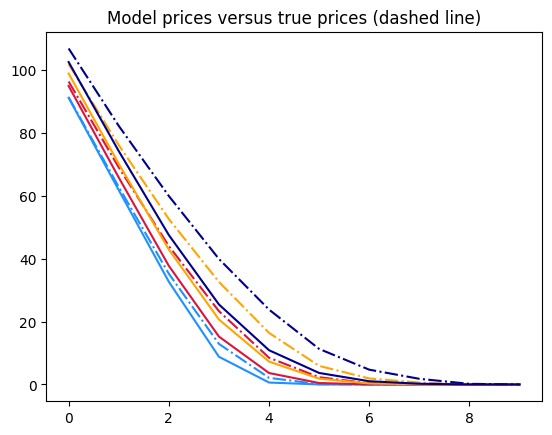

epoch=28, loss=5.5744
epoch: 29
iteration 146, sum_variance=12155.0273, time_forward=0.6238, time_backward=0.1122
iteration 147, sum_variance=13507.9062, time_forward=0.7568, time_backward=0.1697
iteration 148, sum_variance=13890.2998, time_forward=0.8288, time_backward=0.1587
iteration 149, sum_variance=14777.6699, time_forward=0.9563, time_backward=0.1141
iteration 150, sum_variance=13773.5020, time_forward=0.5993, time_backward=0.1139
pred: tensor([[ 9.1131e+01,  6.1782e+01,  3.2640e+01,  8.8029e+00,  6.1606e-01,
          7.9596e-03, -1.9920e-03, -1.6013e-03,  1.2262e-03, -9.9610e-04],
        [ 9.4871e+01,  6.5788e+01,  3.7699e+01,  1.5222e+01,  3.6352e+00,
          4.6099e-01,  2.9639e-02,  3.7508e-03,  3.4668e-04,  2.3252e-03],
        [ 9.8836e+01,  7.0150e+01,  4.2889e+01,  2.0643e+01,  7.2682e+00,
          1.8414e+00,  3.3521e-01,  3.8428e-02, -1.4433e-05,  2.4377e-03],
        [ 1.0248e+02,  7.4186e+01,  4.7486e+01,  2.5426e+01,  1.0884e+01,
          3.6602e+00,  1.0297e+

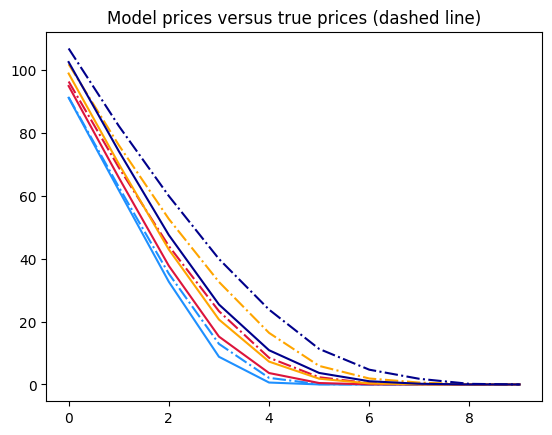

epoch=29, loss=5.5744
epoch: 30
pred tensor([[ 9.1761e+01,  6.2232e+01,  3.3124e+01,  9.1411e+00,  5.9667e-01,
          1.9001e-02, -1.1061e-01, -8.8919e-02,  6.8090e-02, -5.5311e-02],
        [ 9.4345e+01,  6.5333e+01,  3.7014e+01,  1.4501e+01,  3.1365e+00,
          3.3359e-01,  6.1491e-02, -7.0211e-02, -7.2968e-03, -4.8940e-02],
        [ 9.8784e+01,  7.0099e+01,  4.2758e+01,  2.0619e+01,  7.3857e+00,
          1.9238e+00,  4.2893e-01,  1.4382e-01,  6.6248e-03,  1.4082e-02],
        [ 1.0184e+02,  7.3291e+01,  4.6569e+01,  2.4777e+01,  1.0544e+01,
          3.6006e+00,  1.0142e+00,  2.9161e-01, -1.1398e-01,  7.3357e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

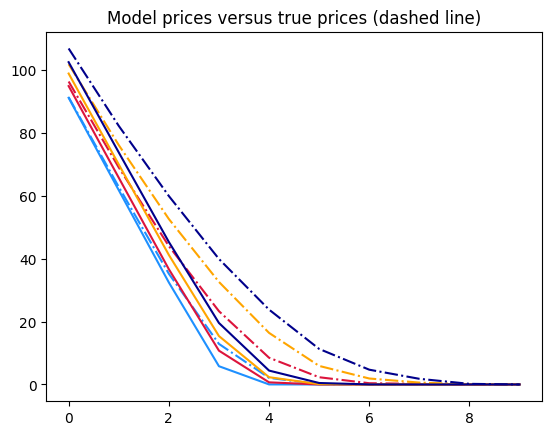

epoch=30, loss=7.5826
epoch: 31
iteration 156, sum_variance=4684.3042, time_forward=0.6511, time_backward=0.1232
iteration 157, sum_variance=4201.3003, time_forward=0.5993, time_backward=0.1102
iteration 158, sum_variance=4615.0889, time_forward=0.6136, time_backward=0.1100
iteration 159, sum_variance=4243.2217, time_forward=0.6188, time_backward=0.1115
iteration 160, sum_variance=4250.4189, time_forward=0.6063, time_backward=0.1103
pred: tensor([[ 9.1123e+01,  6.1776e+01,  3.2432e+01,  5.8048e+00,  1.7830e-02,
          4.3553e-05, -5.9003e-04, -4.6959e-04,  3.5628e-04, -2.8360e-04],
        [ 9.4854e+01,  6.5726e+01,  3.6643e+01,  1.0749e+01,  6.7594e-01,
          4.7095e-03, -4.1307e-04,  9.9031e-04,  8.5924e-05,  6.7636e-04],
        [ 9.8836e+01,  6.9944e+01,  4.1179e+01,  1.5388e+01,  2.3090e+00,
          1.0774e-01,  1.4590e-03,  4.1905e-04,  6.0823e-06,  7.2186e-04],
        [ 1.0245e+02,  7.3770e+01,  4.5295e+01,  1.9548e+01,  4.4151e+00,
          4.6908e-01,  2.0064e-02,  

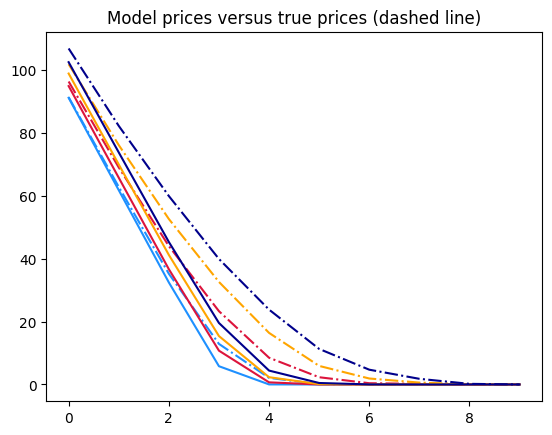

epoch=31, loss=7.5826
epoch: 32
pred tensor([[ 9.1216e+01,  6.1843e+01,  3.2502e+01,  5.7248e+00,  5.2792e-03,
          1.1869e-03, -1.6080e-02, -1.2797e-02,  9.7093e-03, -7.7285e-03],
        [ 9.4980e+01,  6.5823e+01,  3.6764e+01,  1.0762e+01,  5.8448e-01,
          2.8086e-03, -7.4992e-03,  1.7978e-02,  1.5599e-03,  1.2279e-02],
        [ 9.8343e+01,  6.9421e+01,  4.0694e+01,  1.5084e+01,  2.2135e+00,
          2.2967e-02,  7.6094e-02,  6.1052e-02,  8.8614e-04,  1.0517e-01],
        [ 1.0253e+02,  7.3876e+01,  4.5394e+01,  1.9651e+01,  4.4652e+00,
          3.9589e-01,  1.7622e-02, -1.3427e-03,  1.5377e-02, -8.6984e-03]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

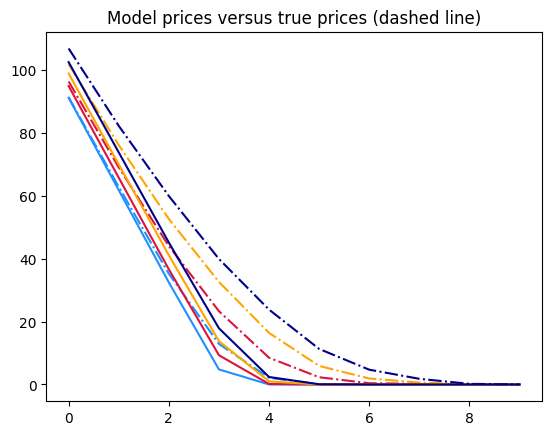

epoch=32, loss=8.1141
epoch: 33
iteration 166, sum_variance=2352.1997, time_forward=0.6211, time_backward=0.1099
iteration 167, sum_variance=2410.9521, time_forward=0.6245, time_backward=0.1111
iteration 168, sum_variance=2432.8394, time_forward=0.6318, time_backward=0.1180
iteration 169, sum_variance=2262.0220, time_forward=0.6140, time_backward=0.1125
iteration 170, sum_variance=2356.4160, time_forward=0.5978, time_backward=0.1191
pred: tensor([[ 9.1122e+01,  6.1775e+01,  3.2430e+01,  4.7817e+00,  4.4461e-04,
          2.0538e-05, -3.2281e-04, -2.5436e-04,  1.9173e-04, -1.4917e-04],
        [ 9.4851e+01,  6.5724e+01,  3.6599e+01,  9.2959e+00,  1.5665e-01,
          1.3306e-05, -2.3340e-04,  5.4631e-04,  4.0494e-05,  3.6523e-04],
        [ 9.8837e+01,  6.9945e+01,  4.1060e+01,  1.3783e+01,  9.7347e-01,
          5.0171e-03,  2.9286e-04,  2.3390e-04,  7.0765e-06,  3.9663e-04],
        [ 1.0245e+02,  7.3769e+01,  4.5107e+01,  1.7861e+01,  2.3766e+00,
          7.0656e-02,  1.3604e-04,  

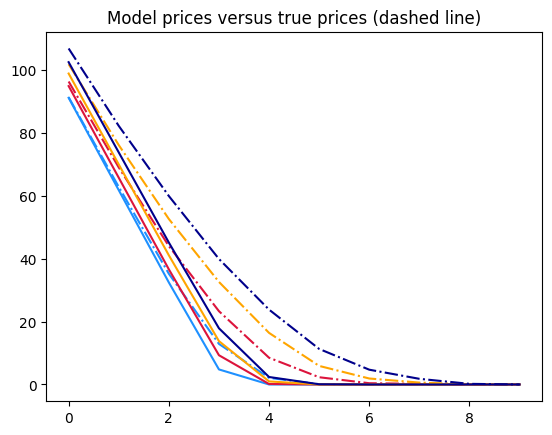

epoch=33, loss=8.1141
epoch: 34
pred tensor([[ 9.1412e+01,  6.1981e+01,  3.2652e+01,  4.8326e+00, -3.6438e-03,
          3.0010e-03, -4.7170e-02, -3.7168e-02,  2.8015e-02, -2.1797e-02],
        [ 9.4566e+01,  6.5504e+01,  3.6355e+01,  8.9730e+00,  8.2183e-02,
         -9.0575e-04,  1.5888e-02, -3.7189e-02, -2.7565e-03, -2.4862e-02],
        [ 9.8772e+01,  6.9876e+01,  4.1004e+01,  1.3671e+01,  1.0211e+00,
         -6.2924e-04,  1.0234e-02,  8.1728e-03,  2.4726e-04,  1.3859e-02],
        [ 1.0271e+02,  7.4122e+01,  4.5481e+01,  1.8059e+01,  2.5412e+00,
          7.2742e-02, -4.9819e-03, -5.2400e-03,  5.0181e-02, -2.8383e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

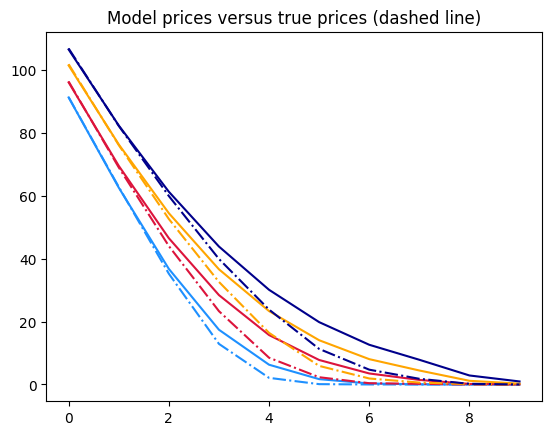

epoch=34, loss=3.8509
epoch: 35
iteration 176, sum_variance=58378.6641, time_forward=0.8999, time_backward=0.1137
iteration 177, sum_variance=64921.3477, time_forward=0.5977, time_backward=0.1128
iteration 178, sum_variance=64304.7969, time_forward=0.6117, time_backward=0.1087
iteration 179, sum_variance=56630.7500, time_forward=0.6756, time_backward=0.1809
iteration 180, sum_variance=61646.5547, time_forward=0.8327, time_backward=0.1518
pred: tensor([[ 9.1240e+01,  6.2571e+01,  3.6739e+01,  1.7392e+01,  6.2795e+00,
          1.6931e+00,  3.1135e-01,  4.2194e-02,  5.0057e-03, -3.7978e-03],
        [ 9.6023e+01,  6.9500e+01,  4.6495e+01,  2.8406e+01,  1.5706e+01,
          7.7779e+00,  3.4994e+00,  1.4453e+00,  1.7844e-01,  2.5357e-02],
        [ 1.0141e+02,  7.6305e+01,  5.4441e+01,  3.6609e+01,  2.3319e+01,
          1.4060e+01,  8.0476e+00,  4.4391e+00,  1.1667e+00,  2.6313e-01],
        [ 1.0649e+02,  8.2323e+01,  6.1258e+01,  4.3846e+01,  3.0093e+01,
          1.9814e+01,  1.2618e+

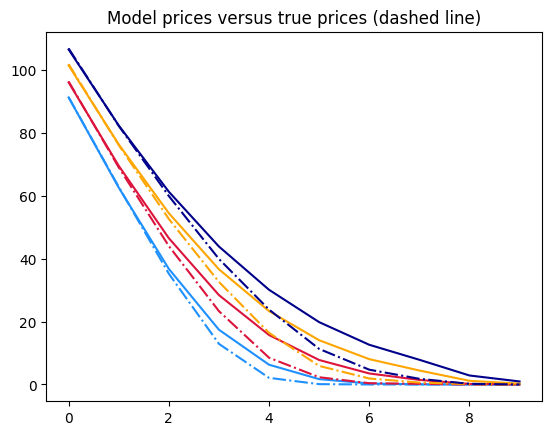

epoch=35, loss=3.8509
epoch: 36
pred tensor([[ 9.0816e+01,  6.2250e+01,  3.6567e+01,  1.7220e+01,  6.2497e+00,
          1.6486e+00,  3.8889e-01,  5.6780e-02, -3.2563e-02,  2.4706e-02],
        [ 9.6994e+01,  7.0375e+01,  4.7048e+01,  2.8499e+01,  1.5694e+01,
          7.4979e+00,  3.2920e+00,  1.4489e+00,  1.9437e-01,  6.9412e-02],
        [ 1.0310e+02,  7.8172e+01,  5.6031e+01,  3.8549e+01,  2.4784e+01,
          1.5193e+01,  8.4596e+00,  4.6807e+00,  1.2425e+00,  1.2374e-01],
        [ 1.0962e+02,  8.6196e+01,  6.5142e+01,  4.6389e+01,  3.2749e+01,
          2.1643e+01,  1.3406e+01,  7.9843e+00,  2.9976e+00,  4.7464e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

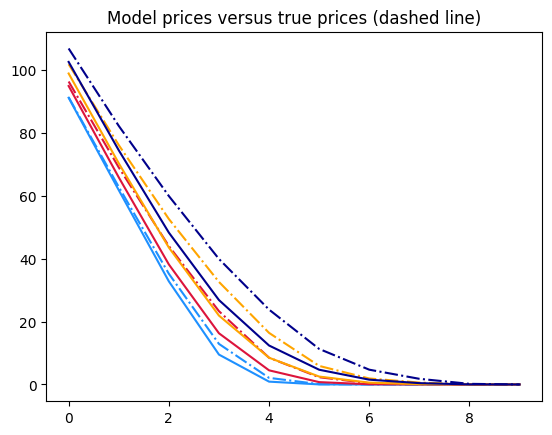

epoch=36, loss=5.0474
epoch: 37
iteration 186, sum_variance=15381.5898, time_forward=0.8730, time_backward=0.1428
iteration 187, sum_variance=13978.7109, time_forward=0.9296, time_backward=0.2226
iteration 188, sum_variance=14063.0605, time_forward=0.6588, time_backward=0.1201
iteration 189, sum_variance=14578.7598, time_forward=0.5981, time_backward=0.1166
iteration 190, sum_variance=14470.9238, time_forward=0.6142, time_backward=0.1111
pred: tensor([[ 9.1134e+01,  6.1786e+01,  3.2785e+01,  9.5034e+00,  8.9994e-01,
          1.9803e-02, -2.0567e-03, -1.5840e-03,  1.1804e-03, -8.7158e-04],
        [ 9.4877e+01,  6.5845e+01,  3.8157e+01,  1.6277e+01,  4.4950e+00,
          7.4719e-01,  6.9735e-02,  6.7719e-03,  1.9094e-04,  2.2593e-03],
        [ 9.8850e+01,  7.0315e+01,  4.3534e+01,  2.1894e+01,  8.4985e+00,
          2.5155e+00,  5.7660e-01,  9.8023e-02,  8.4685e-04,  2.5196e-03],
        [ 1.0252e+02,  7.4455e+01,  4.8270e+01,  2.6835e+01,  1.2386e+01,
          4.6863e+00,  1.5252e+

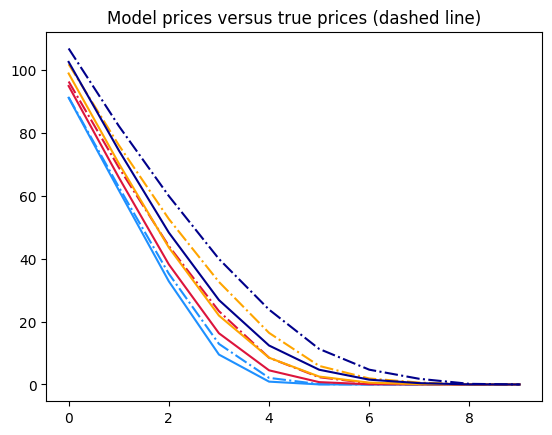

epoch=37, loss=5.0473
epoch: 38
pred tensor([[ 9.1337e+01,  6.1927e+01,  3.2872e+01,  9.0973e+00,  7.9569e-01,
          7.6550e-03, -3.2586e-02, -2.5097e-02,  1.8702e-02, -1.3809e-02],
        [ 9.4366e+01,  6.5445e+01,  3.7761e+01,  1.5803e+01,  4.1758e+00,
          7.1013e-01,  7.5595e-02, -5.9918e-02, -3.2506e-03, -3.8462e-02],
        [ 9.9194e+01,  7.0579e+01,  4.3709e+01,  2.2356e+01,  8.5185e+00,
          2.4622e+00,  3.1807e-01,  1.5847e-03, -2.1732e-03, -5.8593e-02],
        [ 1.0232e+02,  7.4088e+01,  4.7838e+01,  2.6529e+01,  1.2008e+01,
          4.5642e+00,  1.4377e+00,  3.2221e-01, -3.5562e-02,  2.0064e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

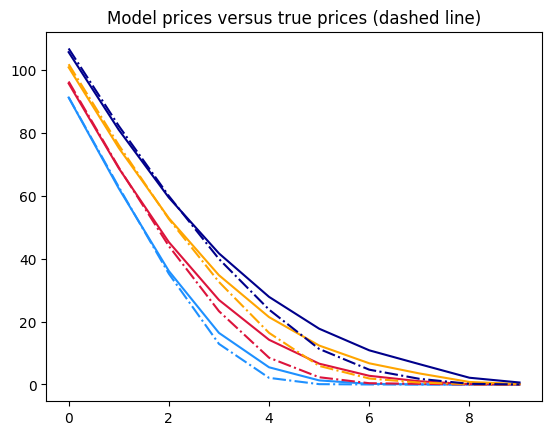

LEARNING RATE UPDATE
epoch=38, loss=2.8788
epoch: 39
iteration 196, sum_variance=51759.5703, time_forward=0.6186, time_backward=0.1196
iteration 197, sum_variance=53122.7266, time_forward=0.6447, time_backward=0.1088
iteration 198, sum_variance=55237.0703, time_forward=0.6230, time_backward=0.1123
iteration 199, sum_variance=49709.8281, time_forward=0.6241, time_backward=0.1100
iteration 200, sum_variance=47756.2461, time_forward=0.6024, time_backward=0.1140
pred: tensor([[ 9.1203e+01,  6.2340e+01,  3.6068e+01,  1.6390e+01,  5.4606e+00,
          1.2937e+00,  1.9654e-01,  2.1042e-02,  3.8816e-03, -2.7847e-03],
        [ 9.5691e+01,  6.8756e+01,  4.5247e+01,  2.6862e+01,  1.4207e+01,
          6.6154e+00,  2.7557e+00,  1.0269e+00,  1.0197e-01,  1.2010e-02],
        [ 1.0080e+02,  7.5208e+01,  5.2868e+01,  3.4732e+01,  2.1409e+01,
          1.2377e+01,  6.7303e+00,  3.5076e+00,  7.9726e-01,  1.5135e-01],
        [ 1.0563e+02,  8.0961e+01,  5.9399e+01,  4.1672e+01,  2.7845e+01,
          

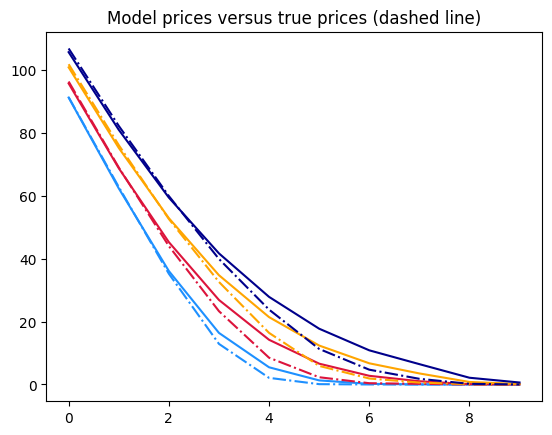

epoch=39, loss=2.8788
epoch: 40
pred tensor([[ 9.1449e+01,  6.2528e+01,  3.6450e+01,  1.6904e+01,  5.8871e+00,
          1.5720e+00,  2.1363e-01, -1.8934e-02,  2.4998e-02, -1.7934e-02],
        [ 9.6826e+01,  6.9438e+01,  4.6012e+01,  2.7648e+01,  1.4937e+01,
          7.1617e+00,  3.0285e+00,  1.4515e+00,  6.7914e-02,  1.1315e-01],
        [ 1.0044e+02,  7.5386e+01,  5.3331e+01,  3.5065e+01,  2.1481e+01,
          1.2075e+01,  6.5876e+00,  3.4331e+00,  6.6463e-01,  1.3357e-01],
        [ 1.0525e+02,  8.0700e+01,  5.9161e+01,  4.1749e+01,  2.7649e+01,
          1.7535e+01,  1.1074e+01,  7.0216e+00,  2.4060e+00,  7.8397e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

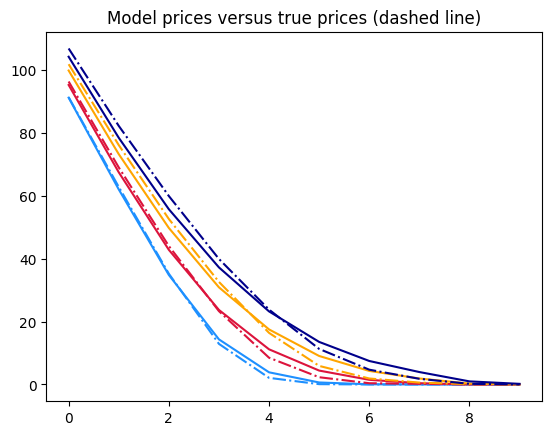

epoch=40, loss=1.8072
epoch: 41
iteration 206, sum_variance=32572.3398, time_forward=0.6330, time_backward=0.1111
iteration 207, sum_variance=35663.9844, time_forward=0.6100, time_backward=0.1126
iteration 208, sum_variance=33981.6797, time_forward=0.6159, time_backward=0.1172
iteration 209, sum_variance=37134.5039, time_forward=0.6176, time_backward=0.1110
iteration 210, sum_variance=36886.2812, time_forward=0.6068, time_backward=0.1150
pred: tensor([[ 9.1163e+01,  6.2007e+01,  3.4804e+01,  1.4330e+01,  3.8635e+00,
          6.3559e-01,  5.7285e-02,  7.0779e-04,  2.6971e-03, -1.8766e-03],
        [ 9.5199e+01,  6.7453e+01,  4.2797e+01,  2.3690e+01,  1.1172e+01,
          4.4169e+00,  1.4778e+00,  4.0505e-01,  2.2550e-02,  5.2005e-03],
        [ 9.9797e+01,  7.3215e+01,  4.9752e+01,  3.0874e+01,  1.7496e+01,
          9.0554e+00,  4.3059e+00,  1.9007e+00,  2.8067e-01,  3.1007e-02],
        [ 1.0417e+02,  7.8420e+01,  5.5707e+01,  3.7212e+01,  2.3222e+01,
          1.3529e+01,  7.4668e+

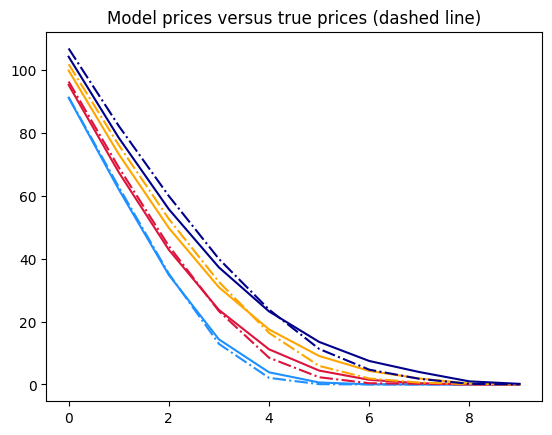

epoch=41, loss=1.8071
epoch: 42
pred tensor([[ 9.2530e+01,  6.3040e+01,  3.5955e+01,  1.5210e+01,  4.0502e+00,
          6.1397e-01, -1.3825e-01, -1.4535e-01,  1.0700e-01, -7.4448e-02],
        [ 9.5613e+01,  6.7589e+01,  4.2440e+01,  2.3255e+01,  1.0886e+01,
          4.2986e+00,  1.3122e+00,  3.5310e-01,  1.0019e-02,  3.4242e-02],
        [ 1.0184e+02,  7.4990e+01,  5.0857e+01,  3.1549e+01,  1.7507e+01,
          9.3228e+00,  4.1634e+00,  1.7801e+00,  3.8098e-01, -2.9734e-01],
        [ 1.0596e+02,  8.0582e+01,  5.7720e+01,  3.7838e+01,  2.4044e+01,
          1.3962e+01,  7.4292e+00,  3.7915e+00,  1.4277e+00,  3.8021e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

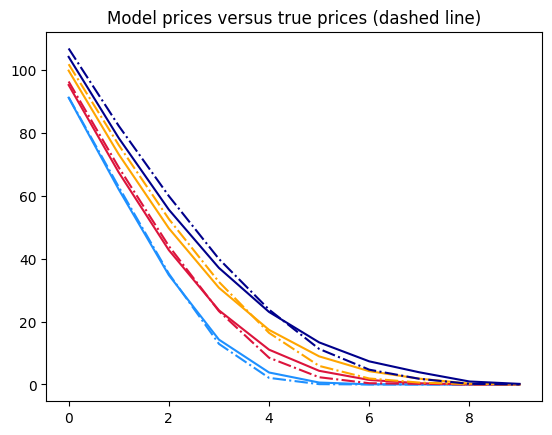

epoch=42, loss=1.8107
epoch: 43
iteration 216, sum_variance=36163.3203, time_forward=0.6387, time_backward=0.1141
iteration 217, sum_variance=36306.1484, time_forward=0.6222, time_backward=0.1081
iteration 218, sum_variance=37305.9609, time_forward=0.6888, time_backward=0.1785
iteration 219, sum_variance=31332.0723, time_forward=0.8023, time_backward=0.1789
iteration 220, sum_variance=36990.5352, time_forward=0.9790, time_backward=0.1600
pred: tensor([[ 9.1161e+01,  6.1998e+01,  3.4760e+01,  1.4254e+01,  3.8068e+00,
          6.1556e-01,  5.4275e-02,  5.5211e-04,  2.4975e-03, -1.6830e-03],
        [ 9.5186e+01,  6.7410e+01,  4.2709e+01,  2.3572e+01,  1.1060e+01,
          4.3402e+00,  1.4379e+00,  3.8882e-01,  2.0898e-02,  4.8318e-03],
        [ 9.9767e+01,  7.3149e+01,  4.9640e+01,  3.0731e+01,  1.7351e+01,
          8.9361e+00,  4.2243e+00,  1.8511e+00,  2.6792e-01,  2.9083e-02],
        [ 1.0413e+02,  7.8334e+01,  5.5574e+01,  3.7047e+01,  2.3050e+01,
          1.3376e+01,  7.3485e+

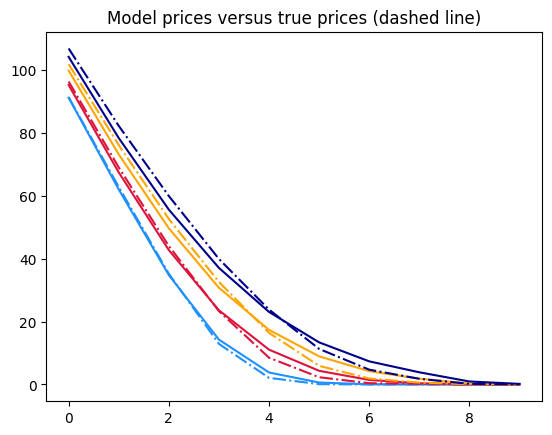

epoch=43, loss=1.8106
epoch: 44
pred tensor([[ 9.1973e+01,  6.2474e+01,  3.5014e+01,  1.4458e+01,  3.7372e+00,
          5.2916e-01, -8.2521e-02, -8.4804e-02,  6.2002e-02, -4.1781e-02],
        [ 9.6588e+01,  6.8533e+01,  4.3857e+01,  2.4572e+01,  1.2044e+01,
          4.7459e+00,  1.4382e+00,  5.8511e-01,  5.3194e-03,  1.0011e-01],
        [ 9.9659e+01,  7.3019e+01,  4.9461e+01,  3.0955e+01,  1.7910e+01,
          9.1427e+00,  4.1762e+00,  1.6186e+00,  1.8688e-01,  3.6599e-02],
        [ 1.0377e+02,  7.8117e+01,  5.5488e+01,  3.7607e+01,  2.3722e+01,
          1.4018e+01,  7.7953e+00,  4.1263e+00,  9.0344e-01,  1.8724e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

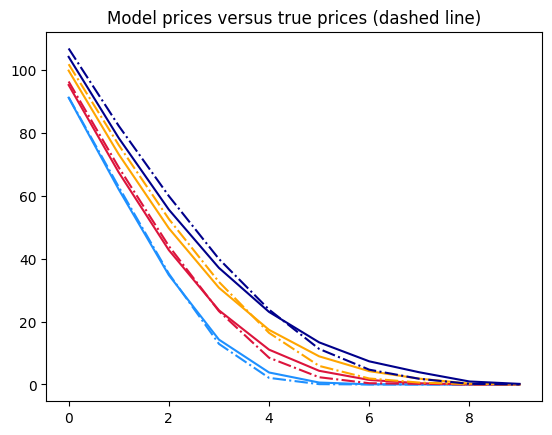

epoch=44, loss=1.8103
epoch: 45
iteration 226, sum_variance=37635.4922, time_forward=0.9771, time_backward=0.1965
iteration 227, sum_variance=33495.8750, time_forward=0.6077, time_backward=0.1210
iteration 228, sum_variance=36001.8203, time_forward=0.5971, time_backward=0.1146
iteration 229, sum_variance=33681.8828, time_forward=0.6163, time_backward=0.1169
iteration 230, sum_variance=33503.2266, time_forward=0.6077, time_backward=0.1117
pred: tensor([[ 9.1161e+01,  6.1998e+01,  3.4763e+01,  1.4258e+01,  3.8099e+00,
          6.1661e-01,  5.4661e-02,  7.6876e-04,  2.3386e-03, -1.5237e-03],
        [ 9.5186e+01,  6.7412e+01,  4.2714e+01,  2.3578e+01,  1.1066e+01,
          4.3443e+00,  1.4402e+00,  3.8941e-01,  2.0934e-02,  4.5415e-03],
        [ 9.9769e+01,  7.3153e+01,  4.9646e+01,  3.0739e+01,  1.7360e+01,
          8.9433e+00,  4.2290e+00,  1.8539e+00,  2.6867e-01,  2.8934e-02],
        [ 1.0413e+02,  7.8339e+01,  5.5582e+01,  3.7057e+01,  2.3061e+01,
          1.3386e+01,  7.3557e+

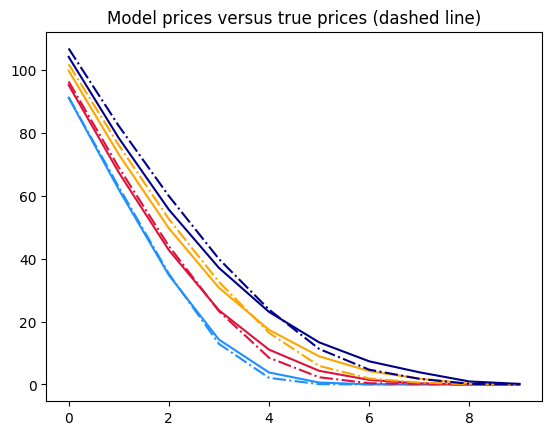

epoch=45, loss=1.8102
epoch: 46
pred tensor([[ 9.0242e+01,  6.1336e+01,  3.4149e+01,  1.3627e+01,  3.6369e+00,
          6.1464e-01,  1.9028e-01,  9.0461e-02, -6.0098e-02,  3.9158e-02],
        [ 9.0906e+01,  6.4094e+01,  3.9142e+01,  2.0000e+01,  8.4503e+00,
          3.5007e+00,  1.2559e+00, -2.3593e-01, -1.2082e-02, -2.6763e-01],
        [ 9.5903e+01,  6.8912e+01,  4.6156e+01,  2.7488e+01,  1.5185e+01,
          6.6266e+00,  3.7835e+00,  1.8103e+00,  2.1836e-01,  6.1682e-01],
        [ 1.0135e+02,  7.4680e+01,  5.1910e+01,  3.4861e+01,  2.0343e+01,
          1.1389e+01,  6.1600e+00,  3.1105e+00,  1.5111e-01,  2.7088e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

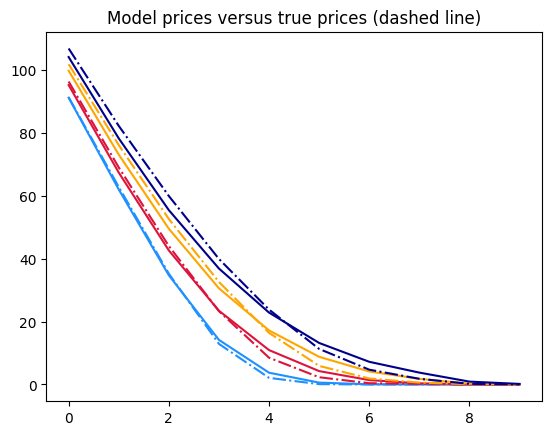

epoch=46, loss=1.8196
epoch: 47
iteration 236, sum_variance=33340.3633, time_forward=0.6312, time_backward=0.1095
iteration 237, sum_variance=32131.7949, time_forward=0.6246, time_backward=0.1075
iteration 238, sum_variance=34952.7617, time_forward=0.6009, time_backward=0.1137
iteration 239, sum_variance=32988.5273, time_forward=0.6254, time_backward=0.1144
iteration 240, sum_variance=34182.8828, time_forward=0.6090, time_backward=0.1080
pred: tensor([[ 9.1160e+01,  6.1987e+01,  3.4708e+01,  1.4162e+01,  3.7394e+00,
          5.9208e-01,  5.1139e-02,  4.9528e-04,  2.1537e-03, -1.3552e-03],
        [ 9.5171e+01,  6.7360e+01,  4.2605e+01,  2.3431e+01,  1.0926e+01,
          4.2490e+00,  1.3913e+00,  3.6985e-01,  1.9000e-02,  4.1961e-03],
        [ 9.9732e+01,  7.3072e+01,  4.9507e+01,  3.0561e+01,  1.7179e+01,
          8.7946e+00,  4.1278e+00,  1.7930e+00,  2.5331e-01,  2.6849e-02],
        [ 1.0408e+02,  7.8233e+01,  5.5416e+01,  3.6850e+01,  2.2846e+01,
          1.3195e+01,  7.2085e+

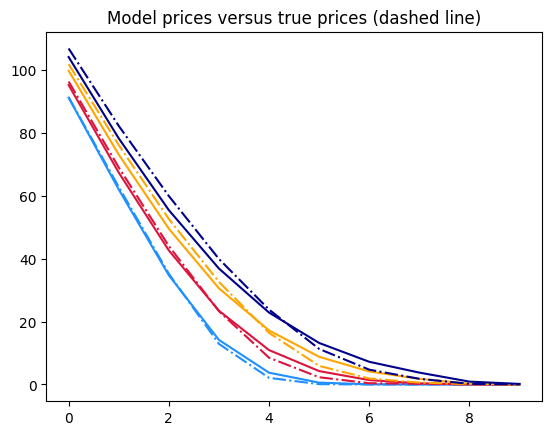

epoch=47, loss=1.8195
epoch: 48
pred tensor([[ 9.2027e+01,  6.2593e+01,  3.5131e+01,  1.4486e+01,  3.6886e+00,
          4.8488e-01, -4.1305e-02, -8.0778e-02,  5.8143e-02, -3.6586e-02],
        [ 9.6331e+01,  6.8248e+01,  4.3485e+01,  2.3918e+01,  1.0595e+01,
          3.4342e+00,  8.6552e-01,  2.9949e-01,  2.7368e-03,  6.4299e-02],
        [ 1.0131e+02,  7.4725e+01,  5.0750e+01,  3.1567e+01,  1.7505e+01,
          9.1128e+00,  3.9680e+00,  1.4715e+00,  1.1207e-01, -2.4164e-01],
        [ 1.0476e+02,  7.9291e+01,  5.6787e+01,  3.7872e+01,  2.3771e+01,
          1.3708e+01,  7.1313e+00,  3.4094e+00,  5.4864e-01, -4.3155e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

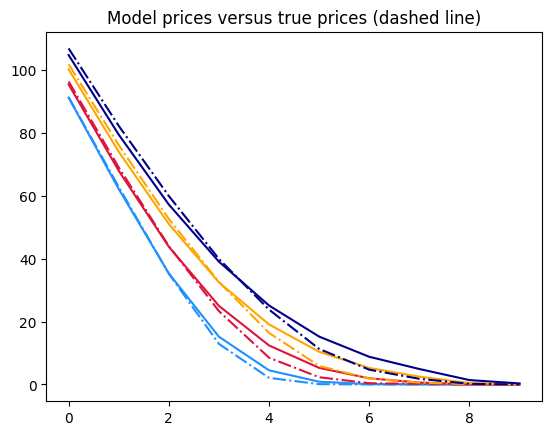

epoch=48, loss=2.0058
epoch: 49
iteration 246, sum_variance=40158.0977, time_forward=0.6181, time_backward=0.1139
iteration 247, sum_variance=40201.0312, time_forward=0.6137, time_backward=0.1082
iteration 248, sum_variance=35061.4688, time_forward=0.6153, time_backward=0.1132
iteration 249, sum_variance=39695.0859, time_forward=0.6323, time_backward=0.1237
iteration 250, sum_variance=38637.6641, time_forward=0.6279, time_backward=0.1080
pred: tensor([[ 9.1174e+01,  6.2119e+01,  3.5297e+01,  1.5168e+01,  4.4971e+00,
          8.7642e-01,  1.0155e-01,  7.3965e-03,  2.3483e-03, -1.4252e-03],
        [ 9.5365e+01,  6.7941e+01,  4.3769e+01,  2.4979e+01,  1.2397e+01,
          5.2775e+00,  1.9518e+00,  6.1408e-01,  4.4395e-02,  5.1150e-03],
        [ 1.0016e+02,  7.3980e+01,  5.0999e+01,  3.2445e+01,  1.9087e+01,
          1.0385e+01,  5.2401e+00,  2.4974e+00,  4.5344e-01,  5.6211e-02],
        [ 1.0471e+02,  7.9408e+01,  5.7189e+01,  3.9027e+01,  2.5106e+01,
          1.5221e+01,  8.8017e+

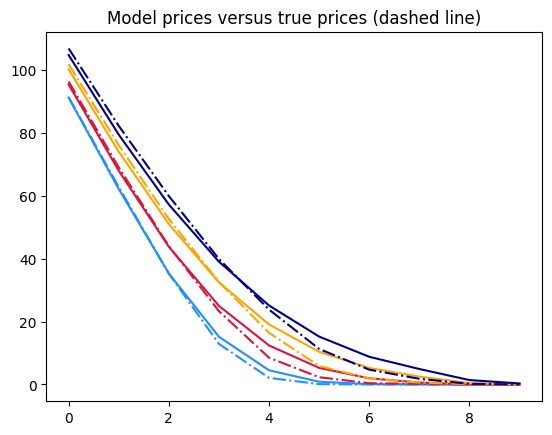

epoch=49, loss=2.0057
epoch: 50
pred tensor([[ 9.3012e+01,  6.3210e+01,  3.6333e+01,  1.5993e+01,  4.8232e+00,
          1.0239e+00, -9.7621e-02, -1.4985e-01,  1.1456e-01, -6.9531e-02],
        [ 9.8221e+01,  6.9781e+01,  4.5372e+01,  2.6159e+01,  1.3298e+01,
          5.5110e+00,  1.6388e+00,  7.5712e-01,  4.7513e-02,  1.7972e-01],
        [ 1.0055e+02,  7.4425e+01,  5.1625e+01,  3.3337e+01,  1.9521e+01,
          1.1101e+01,  5.5981e+00,  2.6290e+00,  4.5132e-01, -7.4713e-02],
        [ 1.0613e+02,  8.1455e+01,  5.9263e+01,  4.0259e+01,  2.6978e+01,
          1.6796e+01,  9.9432e+00,  5.5253e+00,  1.9425e+00,  3.3766e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

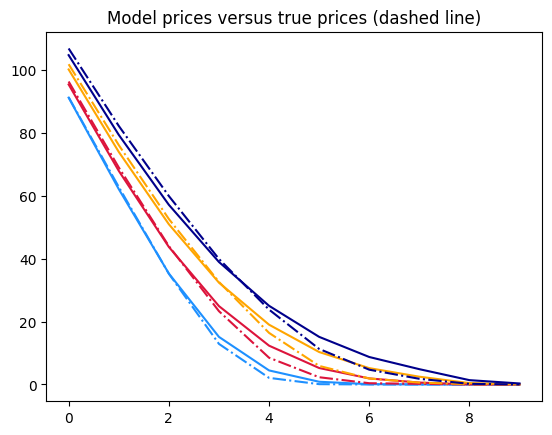

epoch=50, loss=1.9858
epoch: 51
iteration 256, sum_variance=40884.5469, time_forward=0.6207, time_backward=0.1231
iteration 257, sum_variance=39226.1797, time_forward=0.7112, time_backward=0.1516
iteration 258, sum_variance=36227.9219, time_forward=0.8293, time_backward=0.1824
iteration 259, sum_variance=39297.5352, time_forward=0.9622, time_backward=0.1545
iteration 260, sum_variance=37715.5859, time_forward=0.6210, time_backward=0.1087
pred: tensor([[ 9.1173e+01,  6.2112e+01,  3.5271e+01,  1.5125e+01,  4.4641e+00,
          8.6309e-01,  9.9179e-02,  7.2548e-03,  2.1789e-03, -1.2741e-03],
        [ 9.5354e+01,  6.7914e+01,  4.3718e+01,  2.4913e+01,  1.2334e+01,
          5.2322e+00,  1.9260e+00,  6.0129e-01,  4.2950e-02,  4.7075e-03],
        [ 1.0014e+02,  7.3939e+01,  5.0935e+01,  3.2365e+01,  1.9006e+01,
          1.0317e+01,  5.1910e+00,  2.4651e+00,  4.4338e-01,  5.3907e-02],
        [ 1.0468e+02,  7.9357e+01,  5.7113e+01,  3.8935e+01,  2.5010e+01,
          1.5135e+01,  8.7327e+

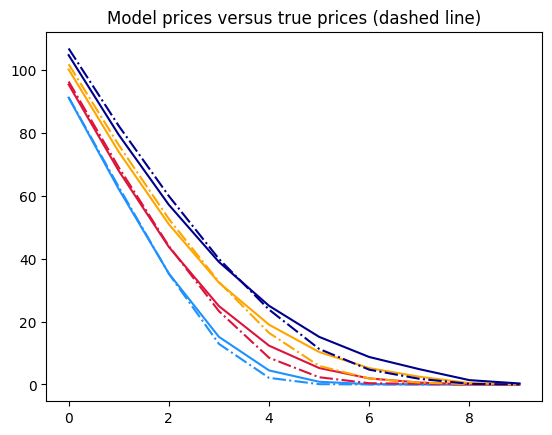

epoch=51, loss=1.9858
epoch: 52
pred tensor([[ 9.2115e+01,  6.2751e+01,  3.5952e+01,  1.5479e+01,  4.4630e+00,
          9.5143e-01,  3.4772e-02, -7.6045e-02,  5.6601e-02, -3.3096e-02],
        [ 9.6160e+01,  6.8587e+01,  4.4359e+01,  2.5158e+01,  1.2191e+01,
          5.0245e+00,  1.8492e+00,  7.0190e-01,  4.3197e-02,  4.8293e-02],
        [ 9.9555e+01,  7.3663e+01,  5.1002e+01,  3.2796e+01,  1.9658e+01,
          1.0789e+01,  5.6486e+00,  2.6761e+00,  5.6147e-01,  1.7716e-01],
        [ 1.0601e+02,  8.1325e+01,  5.9555e+01,  4.0712e+01,  2.6886e+01,
          1.6551e+01,  9.5870e+00,  5.4727e+00,  1.8983e+00,  3.8754e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

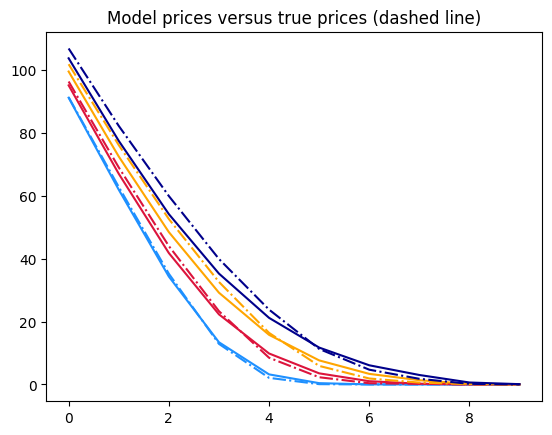

epoch=52, loss=2.0632
epoch: 53
iteration 266, sum_variance=29759.3555, time_forward=0.7857, time_backward=0.1091
iteration 267, sum_variance=30888.8672, time_forward=0.6414, time_backward=0.1248
iteration 268, sum_variance=28310.3906, time_forward=0.6272, time_backward=0.1100
iteration 269, sum_variance=29346.7070, time_forward=0.6129, time_backward=0.1124
iteration 270, sum_variance=27993.8398, time_forward=0.6170, time_backward=0.1142
pred: tensor([[ 9.1152e+01,  6.1916e+01,  3.4304e+01,  1.3418e+01,  3.2041e+00,
          4.2077e-01,  2.8178e-02, -1.3910e-03,  1.5493e-03, -8.7132e-04],
        [ 9.5071e+01,  6.6980e+01,  4.1776e+01,  2.2286e+01,  9.8516e+00,
          3.5378e+00,  1.0401e+00,  2.4308e-01,  7.2123e-03,  3.0372e-03],
        [ 9.9472e+01,  7.2469e+01,  4.8440e+01,  2.9174e+01,  1.5776e+01,
          7.6562e+00,  3.3734e+00,  1.3525e+00,  1.5598e-01,  1.4660e-02],
        [ 1.0368e+02,  7.7437e+01,  5.4146e+01,  3.5245e+01,  2.1179e+01,
          1.1730e+01,  6.0997e+

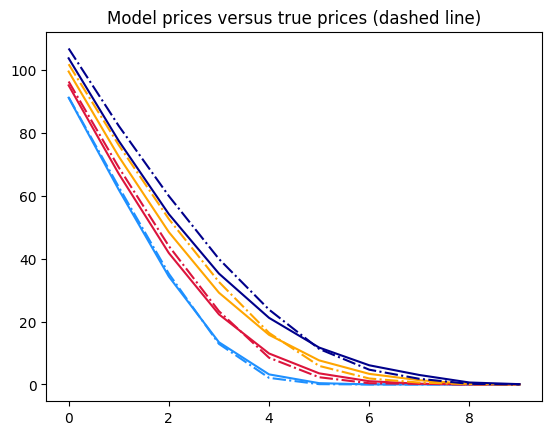

epoch=53, loss=2.0632
epoch: 54
pred tensor([[ 9.0235e+01,  6.1272e+01,  3.3651e+01,  1.2695e+01,  2.8849e+00,
          3.3397e-01,  1.1647e-01,  6.7407e-02, -4.7188e-02,  2.6538e-02],
        [ 9.5207e+01,  6.7019e+01,  4.1586e+01,  2.1864e+01,  9.7174e+00,
          3.4910e+00,  1.0051e+00,  3.1332e-01,  1.2455e-02,  1.1229e-02],
        [ 9.9023e+01,  7.1944e+01,  4.7855e+01,  2.8545e+01,  1.4938e+01,
          6.9053e+00,  2.9515e+00,  1.0876e+00,  1.0163e-01,  5.8591e-02],
        [ 1.0330e+02,  7.7102e+01,  5.3494e+01,  3.4430e+01,  2.0419e+01,
          1.1302e+01,  5.8087e+00,  2.7694e+00,  4.7059e-01,  7.7042e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

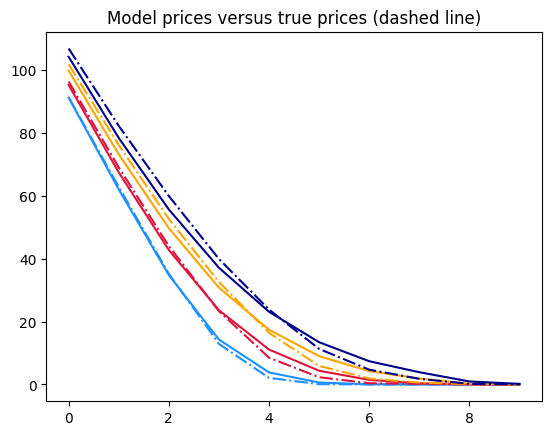

epoch=54, loss=1.8084
epoch: 55
iteration 276, sum_variance=32703.0938, time_forward=0.6739, time_backward=0.1104
iteration 277, sum_variance=31287.1914, time_forward=0.6172, time_backward=0.1298
iteration 278, sum_variance=32841.4570, time_forward=0.6570, time_backward=0.1131
iteration 279, sum_variance=29364.5293, time_forward=0.6108, time_backward=0.1142
iteration 280, sum_variance=32354.8027, time_forward=0.6181, time_backward=0.1149
pred: tensor([[ 9.1160e+01,  6.1999e+01,  3.4773e+01,  1.4277e+01,  3.8238e+00,
          6.2138e-01,  5.6368e-02,  1.7006e-03,  1.6585e-03, -8.9538e-04],
        [ 9.5188e+01,  6.7422e+01,  4.2735e+01,  2.3607e+01,  1.1093e+01,
          4.3625e+00,  1.4502e+00,  3.9195e-01,  2.1160e-02,  3.2571e-03],
        [ 9.9778e+01,  7.3173e+01,  4.9678e+01,  3.0779e+01,  1.7399e+01,
          8.9755e+00,  4.2502e+00,  1.8663e+00,  2.7196e-01,  2.8255e-02],
        [ 1.0415e+02,  7.8365e+01,  5.5619e+01,  3.7102e+01,  2.3107e+01,
          1.3427e+01,  7.3876e+

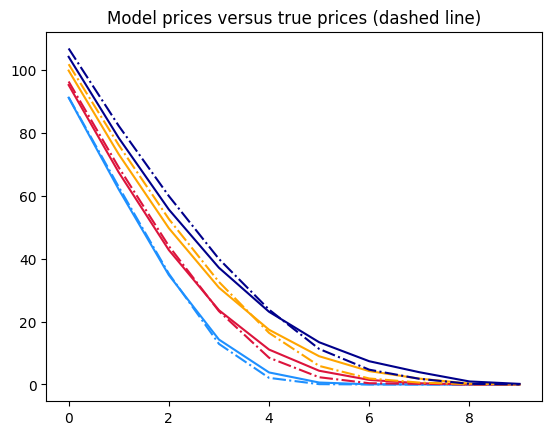

epoch=55, loss=1.8083
epoch: 56
pred tensor([[ 9.1035e+01,  6.1835e+01,  3.4295e+01,  1.3803e+01,  3.3664e+00,
          4.4951e-01,  4.3510e-02,  6.1291e-03, -4.2448e-03,  2.2916e-03],
        [ 9.6026e+01,  6.7926e+01,  4.2817e+01,  2.3371e+01,  1.0940e+01,
          4.1245e+00,  1.2019e+00,  4.0037e-01,  6.1576e-04,  4.5095e-02],
        [ 9.9167e+01,  7.2701e+01,  4.9672e+01,  3.1027e+01,  1.7710e+01,
          8.9450e+00,  4.2860e+00,  1.7583e+00,  1.8293e-01,  1.1672e-01],
        [ 1.0467e+02,  7.9144e+01,  5.6656e+01,  3.7855e+01,  2.3779e+01,
          1.3510e+01,  7.1214e+00,  3.3594e+00,  5.0164e-01,  5.1341e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

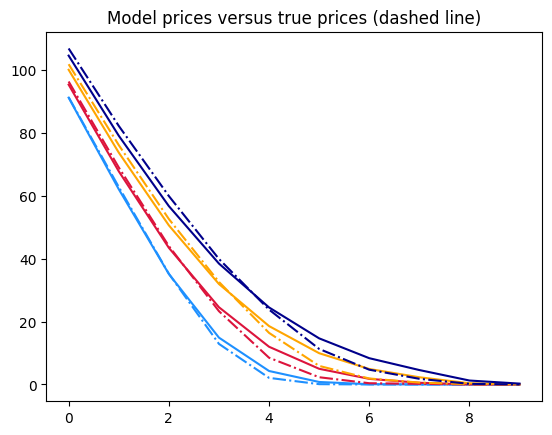

epoch=56, loss=1.8934
epoch: 57
iteration 286, sum_variance=35851.9375, time_forward=0.6542, time_backward=0.1145
iteration 287, sum_variance=37425.7031, time_forward=0.6270, time_backward=0.1098
iteration 288, sum_variance=35970.6406, time_forward=0.6141, time_backward=0.1200
iteration 289, sum_variance=34272.0195, time_forward=0.6164, time_backward=0.1157
iteration 290, sum_variance=36876.5000, time_forward=0.6377, time_backward=0.1474
pred: tensor([[ 9.1169e+01,  6.2076e+01,  3.5130e+01,  1.4890e+01,  4.2840e+00,
          7.9190e-01,  8.6484e-02,  5.9364e-03,  1.6929e-03, -8.7555e-04],
        [ 9.5302e+01,  6.7771e+01,  4.3442e+01,  2.4551e+01,  1.1989e+01,
          4.9862e+00,  1.7877e+00,  5.3598e-01,  3.5683e-02,  3.3310e-03],
        [ 1.0003e+02,  7.3721e+01,  5.0585e+01,  3.1927e+01,  1.8562e+01,
          9.9432e+00,  4.9235e+00,  2.2907e+00,  3.9059e-01,  4.3422e-02],
        [ 1.0453e+02,  7.9076e+01,  5.6698e+01,  3.8429e+01,  2.4485e+01,
          1.4661e+01,  8.3552e+

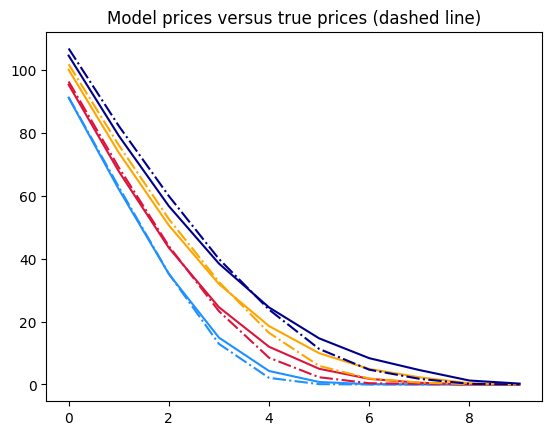

epoch=57, loss=1.8934
epoch: 58
pred tensor([[ 9.1546e+01,  6.2383e+01,  3.5522e+01,  1.4947e+01,  4.1747e+00,
          6.6258e-01,  2.0371e-02, -2.8607e-02,  1.9578e-02, -1.0126e-02],
        [ 9.5834e+01,  6.7963e+01,  4.3343e+01,  2.4190e+01,  1.1279e+01,
          4.3156e+00,  1.3024e+00,  3.9492e-01,  5.2012e-02,  2.8585e-02],
        [ 1.0160e+02,  7.5288e+01,  5.1906e+01,  3.3331e+01,  1.9343e+01,
          1.1115e+01,  5.4821e+00,  2.3964e+00,  4.1920e-01, -1.6263e-01],
        [ 1.0660e+02,  8.1936e+01,  5.9741e+01,  4.0301e+01,  2.6697e+01,
          1.6463e+01,  9.3857e+00,  4.9223e+00,  1.3265e+00,  5.8859e-03]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

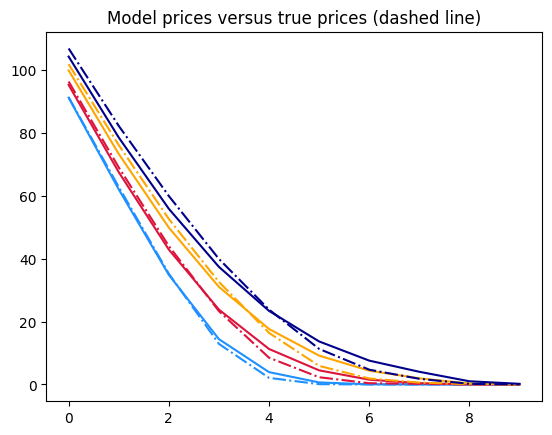

epoch=58, loss=1.8063
epoch: 59
iteration 296, sum_variance=31843.3867, time_forward=0.6290, time_backward=0.1802
iteration 297, sum_variance=31895.0391, time_forward=0.8496, time_backward=0.1435
iteration 298, sum_variance=33046.4453, time_forward=0.9918, time_backward=0.1897
iteration 299, sum_variance=30358.5293, time_forward=0.6237, time_backward=0.1137
iteration 300, sum_variance=33352.1562, time_forward=0.6467, time_backward=0.1098
pred: tensor([[ 9.1162e+01,  6.2013e+01,  3.4843e+01,  1.4401e+01,  3.9152e+00,
          6.5376e-01,  6.2075e-02,  2.6600e-03,  1.4565e-03, -7.2055e-04],
        [ 9.5207e+01,  6.7489e+01,  4.2875e+01,  2.3797e+01,  1.1272e+01,
          4.4856e+00,  1.5154e+00,  4.1763e-01,  2.3744e-02,  2.8704e-03],
        [ 9.9828e+01,  7.3280e+01,  4.9860e+01,  3.1010e+01,  1.7633e+01,
          9.1695e+00,  4.3828e+00,  1.9475e+00,  2.9345e-01,  3.0653e-02],
        [ 1.0422e+02,  7.8506e+01,  5.5836e+01,  3.7370e+01,  2.3386e+01,
          1.3675e+01,  7.5804e+

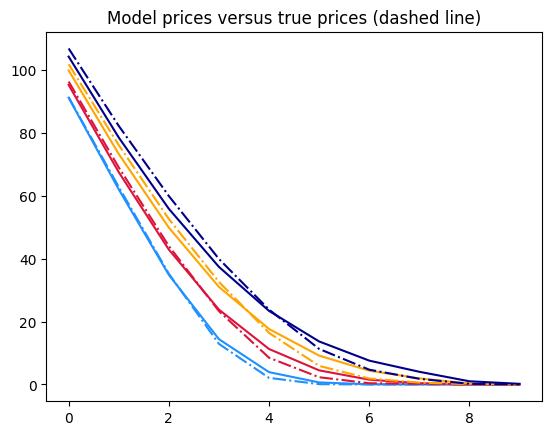

epoch=59, loss=1.8062
epoch: 60
pred tensor([[ 9.0513e+01,  6.1583e+01,  3.4590e+01,  1.4193e+01,  3.9245e+00,
          7.0409e-01,  1.3706e-01,  4.4510e-02, -2.6783e-02,  1.3250e-02],
        [ 9.5536e+01,  6.7402e+01,  4.2765e+01,  2.3807e+01,  1.1184e+01,
          4.6639e+00,  1.6227e+00,  4.5873e-01,  5.9216e-05,  2.2684e-02],
        [ 9.8658e+01,  7.1990e+01,  4.8941e+01,  3.0405e+01,  1.7513e+01,
          8.9480e+00,  4.4125e+00,  2.0516e+00,  3.5716e-01,  1.9282e-01],
        [ 1.0309e+02,  7.7389e+01,  5.4963e+01,  3.7153e+01,  2.3465e+01,
          1.4062e+01,  7.8973e+00,  4.2431e+00,  9.5583e-01,  3.3624e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

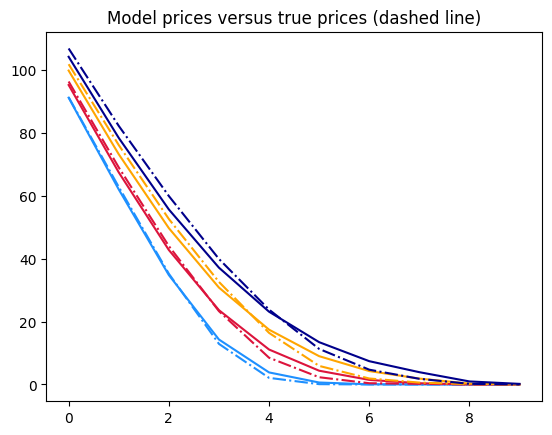

epoch=60, loss=1.8075
epoch: 61
iteration 306, sum_variance=30053.6348, time_forward=0.6450, time_backward=0.1149
iteration 307, sum_variance=29864.9883, time_forward=0.6192, time_backward=0.1119
iteration 308, sum_variance=33830.7344, time_forward=0.6304, time_backward=0.1232
iteration 309, sum_variance=28941.2012, time_forward=0.6337, time_backward=0.1110
iteration 310, sum_variance=32405.4258, time_forward=0.6422, time_backward=0.1117
pred: tensor([[ 9.1160e+01,  6.2000e+01,  3.4779e+01,  1.4288e+01,  3.8313e+00,
          6.2394e-01,  5.7268e-02,  2.1672e-03,  1.3241e-03, -6.2518e-04],
        [ 9.5188e+01,  6.7426e+01,  4.2746e+01,  2.3623e+01,  1.1107e+01,
          4.3722e+00,  1.4556e+00,  3.9329e-01,  2.1322e-02,  2.6127e-03],
        [ 9.9784e+01,  7.3183e+01,  4.9694e+01,  3.0799e+01,  1.7420e+01,
          8.9928e+00,  4.2617e+00,  1.8730e+00,  2.7374e-01,  2.7909e-02],
        [ 1.0415e+02,  7.8378e+01,  5.5639e+01,  3.7126e+01,  2.3132e+01,
          1.3449e+01,  7.4048e+

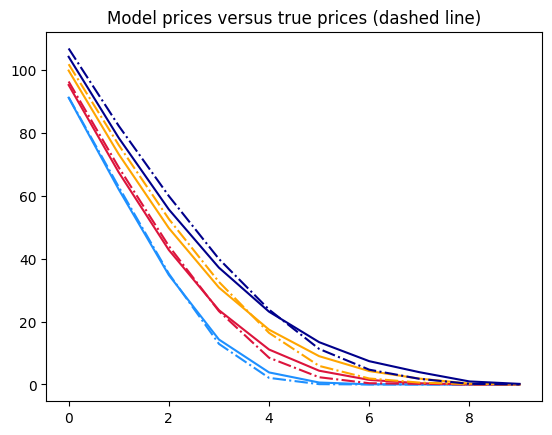

epoch=61, loss=1.8075
epoch: 62
pred tensor([[ 9.0613e+01,  6.1517e+01,  3.3873e+01,  1.3553e+01,  3.3089e+00,
          5.0944e-01,  9.4232e-02,  3.0783e-02, -2.0545e-02,  9.7001e-03],
        [ 9.5588e+01,  6.7497e+01,  4.2520e+01,  2.3251e+01,  1.0947e+01,
          4.5784e+00,  1.7069e+00,  6.3409e-01,  6.9047e-02,  1.8272e-02],
        [ 9.9161e+01,  7.2742e+01,  4.9441e+01,  3.0926e+01,  1.7861e+01,
          9.2603e+00,  4.5835e+00,  1.9770e+00,  3.9164e-01,  2.0308e-01],
        [ 1.0502e+02,  7.9605e+01,  5.7210e+01,  3.9019e+01,  2.5804e+01,
          1.5887e+01,  9.2006e+00,  4.9473e+00,  1.3520e+00,  3.1098e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

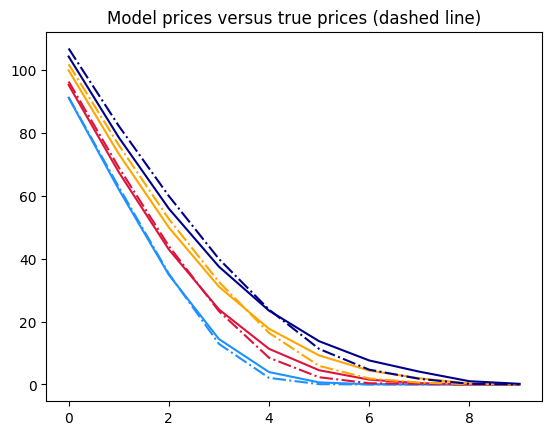

epoch=62, loss=1.8070
epoch: 63
iteration 316, sum_variance=32490.0391, time_forward=0.6399, time_backward=0.1116
iteration 317, sum_variance=29622.8438, time_forward=0.6179, time_backward=0.1120
iteration 318, sum_variance=29289.3945, time_forward=0.6218, time_backward=0.1195
iteration 319, sum_variance=31515.9043, time_forward=0.6191, time_backward=0.1232
iteration 320, sum_variance=32451.4688, time_forward=0.6253, time_backward=0.1070
pred: tensor([[ 9.1162e+01,  6.2017e+01,  3.4863e+01,  1.4436e+01,  3.9412e+00,
          6.6305e-01,  6.3940e-02,  3.1323e-03,  1.2507e-03, -5.6220e-04],
        [ 9.5213e+01,  6.7509e+01,  4.2916e+01,  2.3851e+01,  1.1323e+01,
          4.5202e+00,  1.5340e+00,  4.2467e-01,  2.4449e-02,  2.4692e-03],
        [ 9.9843e+01,  7.3313e+01,  4.9913e+01,  3.1077e+01,  1.7700e+01,
          9.2249e+00,  4.4205e+00,  1.9707e+00,  2.9977e-01,  3.1081e-02],
        [ 1.0424e+02,  7.8547e+01,  5.5899e+01,  3.7447e+01,  2.3466e+01,
          1.3746e+01,  7.6354e+

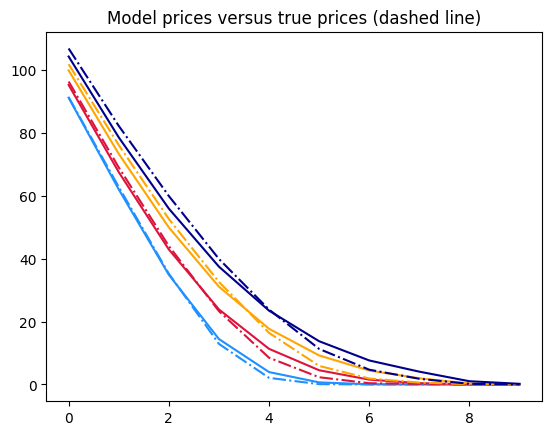

epoch=63, loss=1.8069
epoch: 64
pred tensor([[ 9.1722e+01,  6.2382e+01,  3.5216e+01,  1.4483e+01,  4.0236e+00,
          8.1321e-01,  9.5583e-03, -3.2796e-02,  2.1591e-02, -9.7054e-03],
        [ 9.5792e+01,  6.7877e+01,  4.3056e+01,  2.3478e+01,  1.1043e+01,
          4.6383e+00,  1.6846e+00,  5.5447e-01,  5.7806e-02,  2.1821e-02],
        [ 1.0150e+02,  7.4991e+01,  5.1133e+01,  3.2059e+01,  1.7923e+01,
          9.7370e+00,  4.1534e+00,  1.6139e+00,  2.5217e-01, -1.5848e-01],
        [ 1.0610e+02,  8.1179e+01,  5.8392e+01,  3.8558e+01,  2.4936e+01,
          1.4841e+01,  8.0922e+00,  4.1481e+00,  1.0240e+00, -7.2068e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

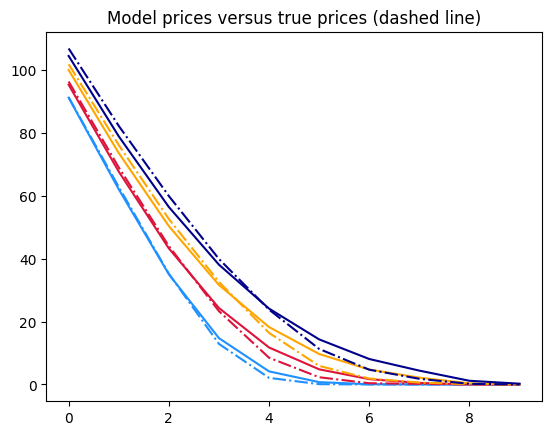

epoch=64, loss=1.8475
epoch: 65
iteration 326, sum_variance=34396.6211, time_forward=0.6675, time_backward=0.1253
iteration 327, sum_variance=32015.5234, time_forward=0.6253, time_backward=0.1137
iteration 328, sum_variance=32418.6816, time_forward=0.6235, time_backward=0.1101
iteration 329, sum_variance=31450.7617, time_forward=0.8619, time_backward=0.1465
iteration 330, sum_variance=32708.1953, time_forward=0.9464, time_backward=0.1796
pred: tensor([[ 9.1165e+01,  6.2053e+01,  3.5033e+01,  1.4727e+01,  4.1601e+00,
          7.4406e-01,  7.8363e-02,  5.2161e-03,  1.2061e-03, -5.1504e-04],
        [ 9.5267e+01,  6.7675e+01,  4.3251e+01,  2.4299e+01,  1.1749e+01,
          4.8168e+00,  1.6946e+00,  4.9336e-01,  3.1174e-02,  2.3814e-03],
        [ 9.9964e+01,  7.3574e+01,  5.0345e+01,  3.1624e+01,  1.8254e+01,
          9.6855e+00,  4.7409e+00,  2.1734e+00,  3.5629e-01,  3.7886e-02],
        [ 1.0442e+02,  7.8886e+01,  5.6413e+01,  3.8079e+01,  2.4121e+01,
          1.4333e+01,  8.0958e+

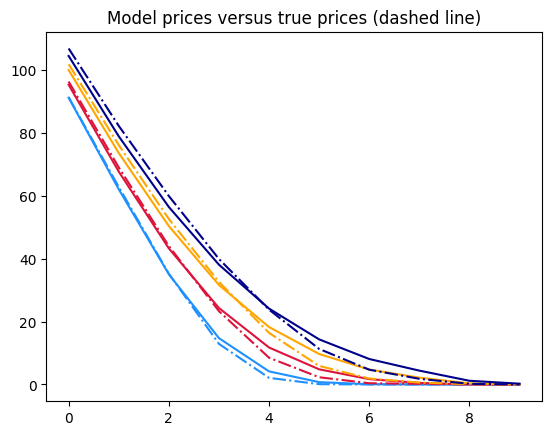

epoch=65, loss=1.8475
epoch: 66
pred tensor([[ 8.9967e+01,  6.1219e+01,  3.4131e+01,  1.3354e+01,  3.1575e+00,
          4.3997e-01,  1.1340e-01,  6.2120e-02, -4.0315e-02,  1.7216e-02],
        [ 9.5701e+01,  6.7731e+01,  4.3235e+01,  2.4249e+01,  1.1367e+01,
          4.3856e+00,  1.6123e+00,  6.6299e-01,  1.1032e-01,  3.3829e-02],
        [ 1.0092e+02,  7.4930e+01,  5.1574e+01,  3.2660e+01,  1.8798e+01,
          1.0229e+01,  4.9398e+00,  2.4602e+00,  6.4198e-01, -2.6072e-02],
        [ 1.0427e+02,  7.8939e+01,  5.6635e+01,  3.8608e+01,  2.4759e+01,
          1.5112e+01,  8.6550e+00,  4.6404e+00,  1.0394e+00,  1.8387e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

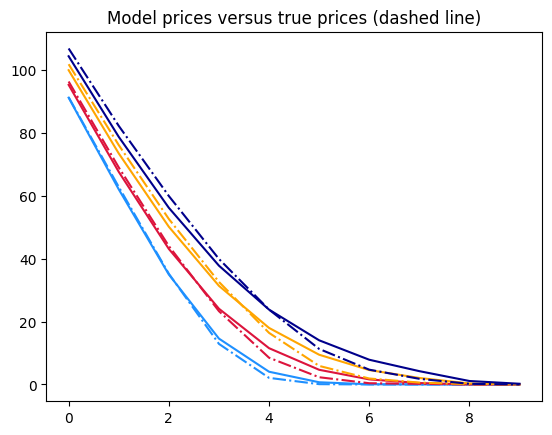

epoch=66, loss=1.8208
epoch: 67
iteration 336, sum_variance=29239.6426, time_forward=0.8329, time_backward=0.1564
iteration 337, sum_variance=30883.7871, time_forward=0.9894, time_backward=0.2054
iteration 338, sum_variance=31347.8125, time_forward=0.6331, time_backward=0.1143
iteration 339, sum_variance=31318.5996, time_forward=0.6279, time_backward=0.1077
iteration 340, sum_variance=31794.0781, time_forward=0.6094, time_backward=0.1086
pred: tensor([[ 9.1163e+01,  6.2034e+01,  3.4947e+01,  1.4581e+01,  4.0499e+00,
          7.0283e-01,  7.1202e-02,  4.2524e-03,  1.0844e-03, -4.3848e-04],
        [ 9.5238e+01,  6.7589e+01,  4.3082e+01,  2.4074e+01,  1.1535e+01,
          4.6674e+00,  1.6133e+00,  4.5763e-01,  2.7544e-02,  2.1438e-03],
        [ 9.9903e+01,  7.3441e+01,  5.0128e+01,  3.1350e+01,  1.7977e+01,
          9.4551e+00,  4.5800e+00,  2.0711e+00,  3.2744e-01,  3.4121e-02],
        [ 1.0433e+02,  7.8714e+01,  5.6155e+01,  3.7763e+01,  2.3794e+01,
          1.4040e+01,  7.8657e+

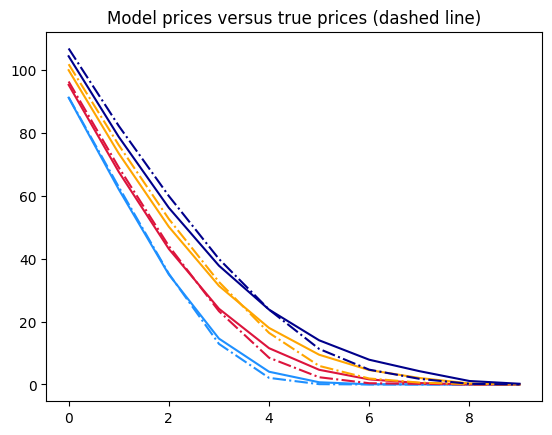

epoch=67, loss=1.8208
epoch: 68
pred tensor([[ 9.3837e+01,  6.3839e+01,  3.6632e+01,  1.5957e+01,  4.4895e+00,
          7.7898e-01, -1.4396e-01, -1.3550e-01,  8.6980e-02, -3.5171e-02],
        [ 9.8850e+01,  7.0002e+01,  4.5330e+01,  2.5706e+01,  1.2192e+01,
          4.4412e+00,  1.2695e+00,  6.4577e-01, -3.1858e-03,  1.1667e-01],
        [ 1.0499e+02,  7.8473e+01,  5.3313e+01,  3.3519e+01,  1.8217e+01,
          1.0672e+01,  4.1808e+00,  1.6431e+00,  3.3589e-01, -5.5794e-01],
        [ 1.0824e+02,  8.3819e+01,  6.0991e+01,  3.9972e+01,  2.6580e+01,
          1.6029e+01,  8.7494e+00,  4.6953e+00,  1.6141e+00, -2.7598e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

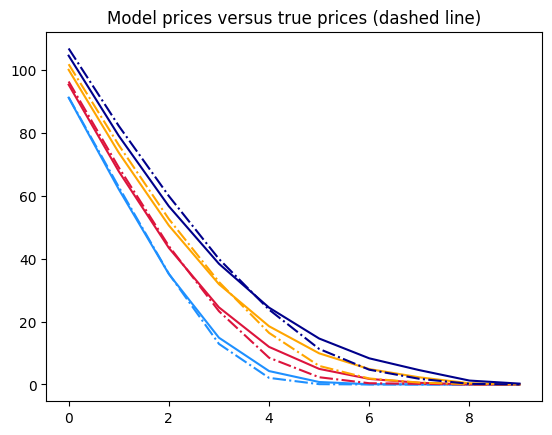

epoch=68, loss=1.8847
epoch: 69
iteration 346, sum_variance=30278.4336, time_forward=0.6481, time_backward=0.1087
iteration 347, sum_variance=33234.2852, time_forward=0.6150, time_backward=0.1094
iteration 348, sum_variance=29010.8008, time_forward=0.6333, time_backward=0.1109
iteration 349, sum_variance=31738.6426, time_forward=0.6241, time_backward=0.1103
iteration 350, sum_variance=30665.3828, time_forward=0.6474, time_backward=0.1194
pred: tensor([[ 9.1167e+01,  6.2071e+01,  3.5112e+01,  1.4862e+01,  4.2626e+00,
          7.8353e-01,  8.5926e-02,  6.5406e-03,  1.0376e-03, -3.9616e-04],
        [ 9.5293e+01,  6.7753e+01,  4.3408e+01,  2.4507e+01,  1.1947e+01,
          4.9565e+00,  1.7721e+00,  5.2726e-01,  3.4858e-02,  2.0559e-03],
        [ 1.0002e+02,  7.3698e+01,  5.0546e+01,  3.1878e+01,  1.8512e+01,
          9.9019e+00,  4.8935e+00,  2.2711e+00,  3.8494e-01,  4.1452e-02],
        [ 1.0451e+02,  7.9045e+01,  5.6652e+01,  3.8373e+01,  2.4427e+01,
          1.4608e+01,  8.3139e+

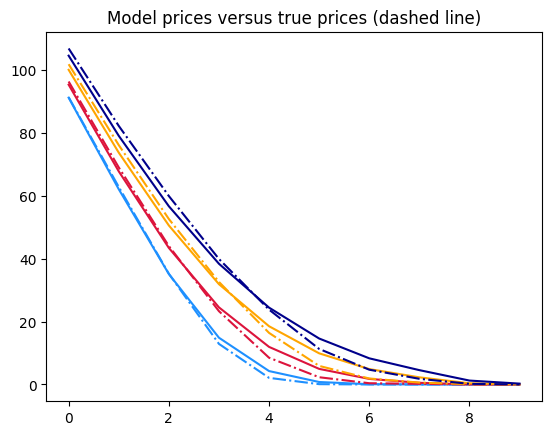

epoch=69, loss=1.8846
epoch: 70
pred tensor([[ 9.2914e+01,  6.3284e+01,  3.6145e+01,  1.5363e+01,  3.8629e+00,
          6.2925e-01, -7.7540e-02, -8.4454e-02,  5.3097e-02, -2.0272e-02],
        [ 9.7152e+01,  6.8902e+01,  4.4188e+01,  2.4951e+01,  1.1849e+01,
          4.6016e+00,  1.4119e+00,  6.2492e-01,  3.8577e-02,  5.5812e-02],
        [ 1.0138e+02,  7.4828e+01,  5.1183e+01,  3.2623e+01,  1.8847e+01,
          1.0328e+01,  4.8852e+00,  2.2319e+00,  6.3837e-01, -9.0619e-03],
        [ 1.0620e+02,  8.1255e+01,  5.8820e+01,  3.9274e+01,  2.5631e+01,
          1.5165e+01,  8.3902e+00,  4.3503e+00,  1.4528e+00,  2.7189e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

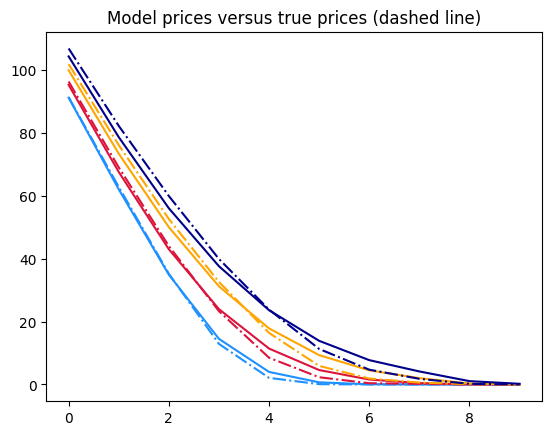

epoch=70, loss=1.8115
epoch: 71
iteration 356, sum_variance=28411.4688, time_forward=0.6455, time_backward=0.1085
iteration 357, sum_variance=33541.7266, time_forward=0.6270, time_backward=0.1097
iteration 358, sum_variance=28359.4531, time_forward=0.6165, time_backward=0.1149
iteration 359, sum_variance=28862.6562, time_forward=0.6269, time_backward=0.1079
iteration 360, sum_variance=32821.5234, time_forward=0.6214, time_backward=0.1090
pred: tensor([[ 9.1162e+01,  6.2024e+01,  3.4899e+01,  1.4498e+01,  3.9880e+00,
          6.8011e-01,  6.7482e-02,  3.9827e-03,  8.9766e-04, -3.2268e-04],
        [ 9.5222e+01,  6.7542e+01,  4.2986e+01,  2.3947e+01,  1.1414e+01,
          4.5836e+00,  1.5685e+00,  4.3800e-01,  2.5774e-02,  1.7827e-03],
        [ 9.9869e+01,  7.3368e+01,  5.0007e+01,  3.1197e+01,  1.7822e+01,
          9.3262e+00,  4.4904e+00,  2.0142e+00,  3.1180e-01,  3.1908e-02],
        [ 1.0428e+02,  7.8620e+01,  5.6011e+01,  3.7586e+01,  2.3610e+01,
          1.3876e+01,  7.7371e+

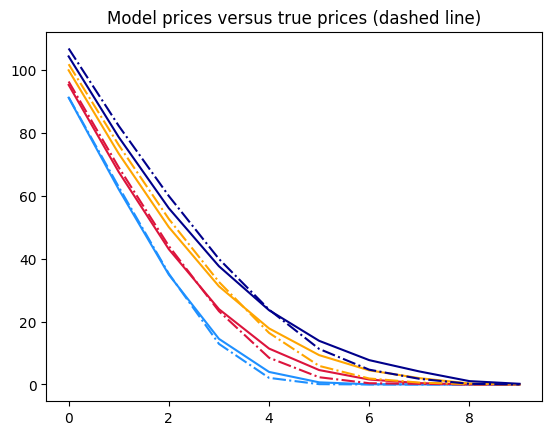

epoch=71, loss=1.8115
epoch: 72
pred tensor([[ 9.0778e+01,  6.1734e+01,  3.4475e+01,  1.3716e+01,  3.3104e+00,
          4.6228e-01,  3.4640e-02,  1.5139e-02, -9.3585e-03,  3.3640e-03],
        [ 9.3888e+01,  6.6401e+01,  4.1664e+01,  2.2806e+01,  1.0502e+01,
          4.3431e+00,  1.5963e+00,  3.6327e-01,  3.5706e-02, -3.2292e-02],
        [ 9.9086e+01,  7.2475e+01,  4.9135e+01,  3.0499e+01,  1.7658e+01,
          9.5106e+00,  4.9613e+00,  2.3269e+00,  3.9874e-01,  7.5214e-02],
        [ 1.0355e+02,  7.7569e+01,  5.4830e+01,  3.6302e+01,  2.2751e+01,
          1.3385e+01,  7.6494e+00,  4.2070e+00,  1.1481e+00,  3.8076e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

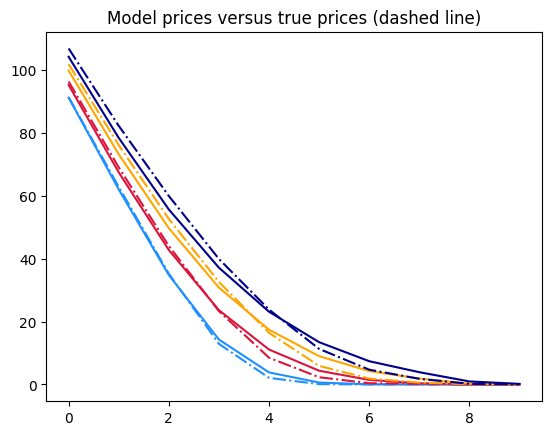

epoch=72, loss=1.8077
epoch: 73
iteration 366, sum_variance=28526.0703, time_forward=0.6489, time_backward=0.1141
iteration 367, sum_variance=30139.1035, time_forward=0.6521, time_backward=0.1103
iteration 368, sum_variance=26926.7578, time_forward=0.6335, time_backward=0.1119
iteration 369, sum_variance=26946.0762, time_forward=0.7162, time_backward=0.1566
iteration 370, sum_variance=28328.8027, time_forward=0.8112, time_backward=0.1673
pred: tensor([[ 9.1159e+01,  6.1998e+01,  3.4773e+01,  1.4279e+01,  3.8249e+00,
          6.2165e-01,  5.7743e-02,  2.8083e-03,  7.9245e-04, -2.6762e-04],
        [ 9.5184e+01,  6.7420e+01,  4.2735e+01,  2.3609e+01,  1.1094e+01,
          4.3631e+00,  1.4516e+00,  3.9025e-01,  2.1096e-02,  1.5756e-03],
        [ 9.9782e+01,  7.3177e+01,  4.9684e+01,  3.0787e+01,  1.7407e+01,
          8.9825e+00,  4.2540e+00,  1.8681e+00,  2.7260e-01,  2.6789e-02],
        [ 1.0415e+02,  7.8371e+01,  5.5628e+01,  3.7112e+01,  2.3118e+01,
          1.3436e+01,  7.3949e+

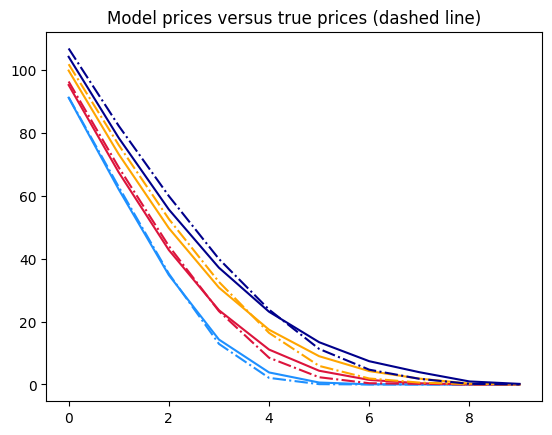

epoch=73, loss=1.8076
epoch: 74
pred tensor([[ 9.1296e+01,  6.1965e+01,  3.4553e+01,  1.3962e+01,  3.5575e+00,
          4.9301e-01,  2.1978e-02, -7.3152e-03,  4.4442e-03, -1.5009e-03],
        [ 9.6233e+01,  6.8188e+01,  4.3483e+01,  2.4007e+01,  1.1142e+01,
          4.2928e+00,  1.3140e+00,  3.1986e-01, -1.3613e-03,  2.5286e-02],
        [ 1.0127e+02,  7.4719e+01,  5.0826e+01,  3.1707e+01,  1.7687e+01,
          9.2698e+00,  4.1644e+00,  1.6019e+00,  1.0664e-01, -1.1287e-01],
        [ 1.0487e+02,  7.9319e+01,  5.6624e+01,  3.7674e+01,  2.3785e+01,
          1.3954e+01,  7.6639e+00,  3.9866e+00,  1.0302e+00,  6.1685e-02]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

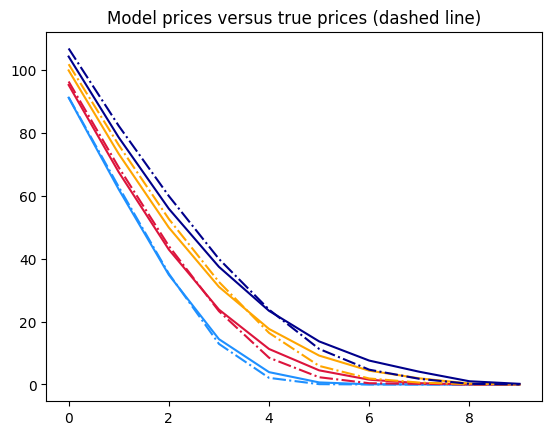

epoch=74, loss=1.8057
epoch: 75
iteration 376, sum_variance=27172.2461, time_forward=0.8924, time_backward=0.1389
iteration 377, sum_variance=27415.2852, time_forward=0.8847, time_backward=0.1831
iteration 378, sum_variance=27711.6328, time_forward=0.8599, time_backward=0.1116
iteration 379, sum_variance=27090.6719, time_forward=0.6253, time_backward=0.1234
iteration 380, sum_variance=27075.0352, time_forward=0.6307, time_backward=0.1095
pred: tensor([[ 9.1160e+01,  6.2013e+01,  3.4847e+01,  1.4408e+01,  3.9202e+00,
          6.5545e-01,  6.3500e-02,  3.6293e-03,  7.3641e-04, -2.3292e-04],
        [ 9.5206e+01,  6.7491e+01,  4.2882e+01,  2.3807e+01,  1.1281e+01,
          4.4914e+00,  1.5194e+00,  4.1724e-01,  2.3802e-02,  1.4652e-03],
        [ 9.9834e+01,  7.3290e+01,  4.9874e+01,  3.1028e+01,  1.7650e+01,
          9.1839e+00,  4.3916e+00,  1.9525e+00,  2.9492e-01,  2.9505e-02],
        [ 1.0423e+02,  7.8518e+01,  5.5854e+01,  3.7391e+01,  2.3407e+01,
          1.3694e+01,  7.5948e+

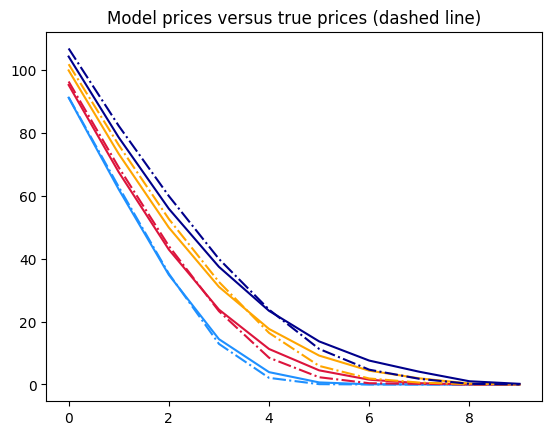

epoch=75, loss=1.8056
epoch: 76
pred tensor([[ 8.9424e+01,  6.0903e+01,  3.3776e+01,  1.3110e+01,  3.5654e+00,
          5.0544e-01,  1.7532e-01,  6.5663e-02, -3.9167e-02,  1.2388e-02],
        [ 9.3168e+01,  6.6204e+01,  4.1550e+01,  2.2418e+01,  1.0268e+01,
          4.2230e+00,  1.5412e+00,  4.0587e-01,  3.6008e-02, -4.4484e-02],
        [ 9.7453e+01,  7.1107e+01,  4.8435e+01,  3.0183e+01,  1.7475e+01,
          8.3776e+00,  4.2086e+00,  1.8990e+00,  3.0550e-01,  2.1305e-01],
        [ 1.0216e+02,  7.5792e+01,  5.3246e+01,  3.6107e+01,  2.1886e+01,
          1.2774e+01,  7.1724e+00,  3.5391e+00,  4.0252e-01,  1.1277e-01]],
       device='cuda:0', grad_fn=<CopySlices>)
target_mat_T tensor([[9.1300e+01, 6.2800e+01, 3.5200e+01, 1.2900e+01, 2.1000e+00, 1.0000e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6300e+01, 6.9000e+01, 4.4000e+01, 2.3300e+01, 8.5000e+00, 2.3000e+00,
         4.0000e-01, 2.0000e-01, 0.0000e+00, 0.0000e+00],
        [1.0180e+02, 7.6100e+

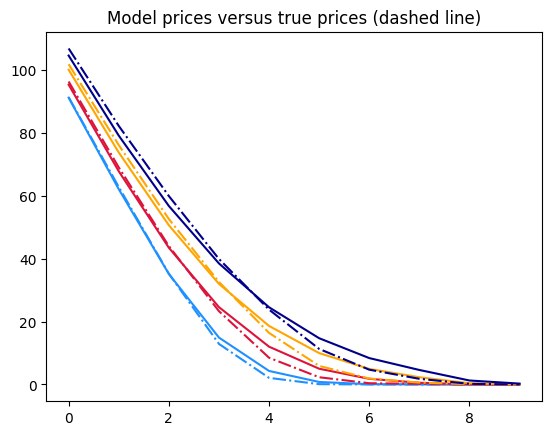

epoch=76, loss=1.8990
epoch: 77
iteration 386, sum_variance=32804.8203, time_forward=0.6379, time_backward=0.1135
iteration 387, sum_variance=28372.5898, time_forward=0.6162, time_backward=0.1099
iteration 388, sum_variance=30837.3281, time_forward=0.6340, time_backward=0.1112
iteration 389, sum_variance=31337.6816, time_forward=0.6110, time_backward=0.1196
iteration 390, sum_variance=28814.7500, time_forward=0.6149, time_backward=0.1071
pred: tensor([[ 9.1167e+01,  6.2077e+01,  3.5141e+01,  1.4910e+01,  4.2981e+00,
          7.9721e-01,  8.9007e-02,  7.3331e-03,  7.2186e-04, -2.1306e-04],
        [ 9.5302e+01,  6.7780e+01,  4.3463e+01,  2.4579e+01,  1.2014e+01,
          5.0038e+00,  1.7986e+00,  5.3817e-01,  3.6043e-02,  1.4575e-03],
        [ 1.0005e+02,  7.3745e+01,  5.0620e+01,  3.1969e+01,  1.8602e+01,
          9.9771e+00,  4.9458e+00,  2.3044e+00,  3.9478e-01,  4.2236e-02],
        [ 1.0455e+02,  7.9106e+01,  5.6740e+01,  3.8477e+01,  2.4534e+01,
          1.4704e+01,  8.3890e+

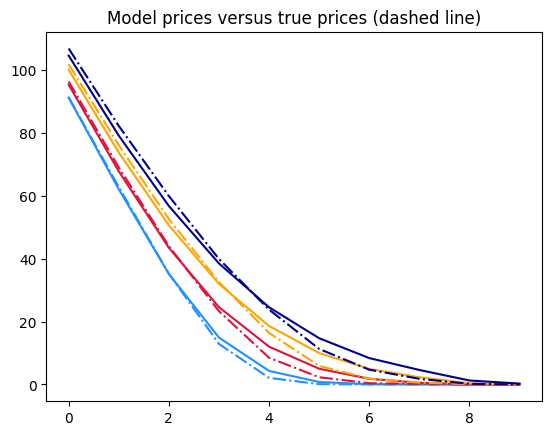

epoch=77, loss=1.8990
epoch: 78


In [ ]:

n_steps=252
timegrid = torch.linspace(0,1,n_steps+1).to(device)
maturity_times=[44, 107, 175,237]
ttms = [0.175,0.425,0.695,0.94]
n_maturities = len(maturities)

S0 = 590
rate = 0.03# risk-free rate
model = Net_LSV(dim=1, timegrid=timegrid, strikes_call=strikes*S0, n_layers=10, vNetWidth=100, device=device, n_maturities=n_maturities, maturities=maturity_times, rate=rate)
model.to(device)
model.apply(init_weights)

    # Monte Carlo test data
MC_samples_test=5000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0) # We will use antithetic Brownian paths for testing

    # Logging file
with open("error_hedge.txt","w") as f:
    f.write("epoch,error_hedge_2,error_hedge_inf\n")

CONFIG = {"batch_size":1000,
            "n_epochs":100,
            "maturities":maturity_times,
            "ttms":ttms,
            "n_maturities":n_maturities,
            "strikes_call":strikes*S0,
            "timegrid":timegrid,
            "n_steps":n_steps,
            "target_data":data_options}

model5= train_nsde(model, z_test, CONFIG)